In [ ]:
# Model (NM2) #
# Definition...
# Scoring_days = Max(Last Request date, Last Trip date, SRP Data Collection Start Date) - SRP Data Collection Start Date + 1
# If we choose to use SRP Final Score Date...
# Scoring_days = SRP Final Score Date - SRP Data Collection Start Date + 1

# SRP Version (NM1) #
# Scoring_days = Max(Last Request date prior to SRP Final Score Date) - Registration Date

# Heartbeat Data:
# Last Request date
# Registration date

# CMT Data:
# Last Trip date

# Additional model variables for scoring

# SRP Data:
# SRP Data Collection Start Date = data_clctn_start_date = Registration date (reset)
# SRP Final Score Date

# GOAL: Compare NM2 Scoring_days to NM1 Scoring_days
# Using our model, what will SRP score look like? 

# Step 1:
# Sam send Shaja - short_user_id, Max_SRP_Final_Score_Date, Min_SRP_Data_Collecion_Start_Date
# Step 2: 
# Shaja send Sam driver summary - short_user_id, Last Trip date, model summary variables
# Step 3: 
# Sam inner merge with Heartbeat data (Heartbeat Last Request date =< SRP Final Score Date)

# SRP Final Score Date > Max(Last Request date, Last Trip date, SRP Data Collection Start Date) > SRP Data Collection Start Date
# 3/03/2021            > Max(12/04/2020,            12/01/2020,                      6/05/2020) > 6/05/2020
# 3/03/2021            > Max(NaN,                   12/01/2020,                      6/05/2020) > 6/05/2020

# Scoring_days = Max(Last Request date, Last Trip date, SRP Data Collection Start Date) - SRP Data Collection Start Date + 1

In [ ]:
# Replace data_collection_start_date with registration_date

In [ ]:
# New proposal 4/13/2021
# registration_date is the date when a new short_user_id first logs in to the app and it stays the same 
# if someone re-enrolls with the same user id.  Based on this information, the data collection start date 
# for new customers should be "registration date"; 
# for re-enrollment with the same id, the closest we can get is the "Min(Last Request Date >= Re-Enrollment Date)".

# Old way: 
# Scoring_days = Max(Last Request date, Last Trip date, SRP Data Collection Start Date) - SRP Data Collection Start Date + 1

# New way:
# Scoring_days = Max(Last Request date, Last Trip date, SRP Data Collection Start Date) - SRP Data Collection Start Date + 1
# Min(Last Request Date >= Re-Enrollment Date)

# Import Data and Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from pyathena import connect
import boto3

In [2]:
# Load SRM data from Michael
srm_dt = pd.read_excel('SRM Scoring Data and Data Clctn.xlsx')

# Show head
print(srm_dt.shape)
srm_dt.head()

(141530, 23)


,policy_nb,channel_cd,rate_state_abbr_nm,enrollment_effective_dt,enrollment_process_dt,estmt_completion_dt,estmt_discount_apply_dt,program_add_date,program_end_date,data_clctn_start_date,...,program_type_cd,src_clctn_subject_key_id,final_score_date,score_type_cd,score_qt,final_discount_date,discount_type_cd,discount_pc,vendor_id,vendor_account_nb
0,5106L 005381,EA,CT,2018-09-14,2018-09-18,2019-05-14,2019-07-03,2020-09-21,2019-05-16,2018-07-05,...,SRM,1,2018-11-16,DF,167,2019-05-16,DF,12,LN,7d922b80-21a2-445d-a171-91da4fb4576d
1,5106L 005381,EA,CT,2018-09-14,2018-09-18,2019-05-14,2019-07-03,2020-09-21,2019-05-16,2018-07-05,...,SRM,1,2020-11-17,PF,84,2020-11-17,PF,13,LN,7d922b80-21a2-445d-a171-91da4fb4576d
2,5106L 006339,EA,CT,2018-07-05,2018-07-09,2018-11-16,2019-01-05,2020-09-21,2018-11-20,2018-07-09,...,SRM,1,2018-11-20,DF,161,2018-11-20,DF,21,LN,3510c8ac-6510-40c8-8790-fd010a022d08
3,5106L 006339,EA,CT,2018-07-05,2018-07-09,2018-11-16,2019-01-05,2020-09-21,2018-11-20,2018-07-09,...,SRM,1,2020-11-17,PF,68,2020-11-17,PF,25,LN,3510c8ac-6510-40c8-8790-fd010a022d08
4,5106L 006339,EA,CT,2018-07-05,2018-07-09,2018-11-16,2019-01-05,2020-09-21,2018-11-20,2018-07-09,...,SRM,2,2018-11-20,DF,129,2018-11-20,DF,29,LN,73837a16-cbe7-4af1-a49c-e3f0b56ffc1f


In [3]:
# Count unique policy numbers
print('SRM data has ' + str(srm_dt['vendor_account_nb'].nunique()) + ' unique drivers.')

SRM data has 81555 unique drivers.


In [4]:
# First filter data to start at 6/05/2020
srm_dt2 = srm_dt[srm_dt['data_clctn_start_date'] >= '2020-06-05']
srm_dt2 = srm_dt2[srm_dt2['final_score_date'] >= '2020-06-05']
print('Filter by >= 2020-06-05: SRM data has ' + str(srm_dt2['vendor_account_nb'].nunique()) + ' unique drivers.')
print('We lose ' + str(81555-16357) + ' drivers')
print('We lose ' + str(141530-31746) + ' rows')
print(srm_dt2.shape)

# Filter by vendor_id = "CMT"
srm_dt2 = srm_dt2[srm_dt2['vendor_id'] == 'CMT']
print('Filter by vendor_id = "CMT": SRM data has ' + str(srm_dt2['vendor_account_nb'].nunique()) + ' unique drivers.')
print('We lose ' + str(16357-16108) + ' drivers')
print('We lose ' + str(31746-31251) + ' rows')
print(srm_dt2.shape)

# Filter by score_type_cd = "DF"
# Added on 3/09/2021
srm_dt2 = srm_dt2[srm_dt2['score_type_cd'] == 'DF']
print('Filter by score_type_cd = "DF": SRM data has ' + str(srm_dt2['vendor_account_nb'].nunique()) + ' unique drivers.')
print('We lose ' + str(16108-16108) + ' drivers')
print('We lose ' + str(31251-16207) + ' rows')
print(srm_dt2.shape)

# Filter by policy_status != "A"
# Added on 3/11/2021
srm_dt2 = srm_dt2[srm_dt2['policy_status'] == 'A']
print('Filter by policy_status != "A": SRM data has ' + str(srm_dt2['vendor_account_nb'].nunique()) + ' unique drivers.')
print('We lose ' + str(16108-15246) + ' drivers')
print('We lose ' + str(16207-15327) + ' rows')
print(srm_dt2.shape)

# Then select only variables we need
# Added discount_pc and score_qt on 3/09/2021
# Added channel_cd, rate_state_abbr_nm on 3/10/2021
# Add enrollment_effective_dt to get most recent for cases of duplication 3/10/2021
# Add estmt_completion_dt to get most recent for cases of duplication 3/10/2021
srm_dt2 = srm_dt2[['vendor_account_nb','data_clctn_start_date','final_score_date','discount_pc','score_qt'
                  ,'channel_cd','rate_state_abbr_nm','enrollment_effective_dt','estmt_completion_dt']]

# Remove NaN vendor_account_nb's
srm_dt3 = srm_dt2[srm_dt2['vendor_account_nb'].notna()]
print('Filter by NaN vendor_account_nbs: SRM data has ' + str(srm_dt3['vendor_account_nb'].nunique()) + ' unique drivers.')
print('We lose ' + str(15246-15246) + ' drivers')
print('We lose ' + str(15327-15280) + ' rows')
print(srm_dt3.shape)
      
# Dedup
srm_dt4 = srm_dt3.drop_duplicates()
print('After Dedup...')
print('We lose ' + str(15280-15270) + ' rows')

print(srm_dt4.shape)
srm_dt4.head()

# Previously
# Goes from 141,530 rows to 31,251 (difference = 110,279)
# Goes from 31,251 rows to 20,472 (difference = 10,779)
# After 3/09/2021
# Goes from 141,530 rows to 16,207 (difference = 125,323)
# Goes from 16,207 rows to 16,183 (difference = 24)
# After 3/10/2021
# Goes from 16,207 rows to 16,184 (difference = 23)
# Goes from 16,207 rows to 16,187 (difference = 20)

# Goes from 16,154 rows to 16,137 current (3x)

# 15,327->15,280->15,270 current

Filter by >= 2020-06-05: SRM data has 16357 unique drivers.
We lose 65198 drivers
We lose 109784 rows
(31746, 23)
Filter by vendor_id = "CMT": SRM data has 16108 unique drivers.
We lose 249 drivers
We lose 495 rows
(31251, 23)
Filter by score_type_cd = "DF": SRM data has 16108 unique drivers.
We lose 0 drivers
We lose 15044 rows
(16207, 23)
Filter by policy_status != "A": SRM data has 15246 unique drivers.
We lose 862 drivers
We lose 880 rows
(15327, 23)
Filter by NaN vendor_account_nbs: SRM data has 15246 unique drivers.
We lose 0 drivers
We lose 47 rows
(15280, 9)
After Dedup...
We lose 10 rows
(15270, 9)


,vendor_account_nb,data_clctn_start_date,final_score_date,discount_pc,score_qt,channel_cd,rate_state_abbr_nm,enrollment_effective_dt,estmt_completion_dt
27,11245245,2020-07-02,2020-12-18,25,153,EA,CT,2020-08-05,2020-12-17
100,67163621,2020-08-27,2021-01-12,28,136,EA,CT,2020-09-02,2021-01-11
108,17262410,2020-10-13,2021-01-21,32,98,EA,CT,2020-10-13,2021-01-20
423,88419143,2020-06-09,2020-10-30,28,143,EA,CT,2020-06-09,2020-10-29
695,63914697,2020-07-22,2021-01-25,32,108,EA,CT,2020-07-22,2021-01-22


In [7]:
# Count unique policy numbers
print('SRM data has ' + str(srm_dt4['vendor_account_nb'].nunique()) + ' unique drivers.')

# Driver count goes from 81,555 to 16,108 (difference = 65,447 / 80% of original data)
# After 3/11/2021 goes from 16,108 to 15,246

SRM data has 15246 unique drivers.


In [8]:
# First change vendor_account_nb to str
srm_dt4['vendor_account_nb'] = srm_dt4['vendor_account_nb'].astype('str') 

# Filter by max(enrollment_effective_dt)
idx = srm_dt4.groupby(['vendor_account_nb'])['enrollment_effective_dt'].transform(max) == srm_dt4['enrollment_effective_dt']
srm_dt5 = srm_dt4[idx]
print('Filter by max(enrollment_effective_dt): SRM data has ' + str(srm_dt5['vendor_account_nb'].nunique()) + ' unique drivers.')
print(srm_dt5.shape)
print('Difference of:' + str(15270-15251))
# 16137 -> 16113

# Filter by max(estmt_completion_dt)
idx = srm_dt5.groupby(['vendor_account_nb'])['estmt_completion_dt'].transform(max) == srm_dt5['estmt_completion_dt']
srm_dt6 = srm_dt5[idx]
print('Filter by max(estmt_completion_dt): SRM data has ' + str(srm_dt6['vendor_account_nb'].nunique()) + ' unique drivers.')
print(srm_dt6.shape)
# 16113 -> 16112

# Filter by min(data_clctn_start_date)
activedays_min = srm_dt6.groupby('vendor_account_nb')['data_clctn_start_date'].min()

# Merge to get only min
srm_dt_min = pd.merge(srm_dt6, activedays_min.to_frame(), on="vendor_account_nb")
srm_dt_min.columns = ['vendor_account_nb','data_clctn_start_date','final_score_date'
                      ,'NM1_discount_pc','NM1_score_qt','NM1_channel_cd','NM1_rate_state_abbr_nm'
                      ,'enrollment_effective_dt','estmt_completion_dt','Min_data_clctn_start_date']
srm_dt_min2 = srm_dt_min[['vendor_account_nb','final_score_date','Min_data_clctn_start_date'
                          ,'NM1_discount_pc','NM1_score_qt','NM1_channel_cd','NM1_rate_state_abbr_nm']]
print('Filter by min(data_clctn_start_date): SRM data has ' + str(srm_dt_min2['vendor_account_nb'].nunique()) + ' unique drivers.')
print(srm_dt_min2.shape)


# Filter by max(final_score_date)
activedays_max = srm_dt_min2.groupby('vendor_account_nb')['final_score_date'].max()

# Merge to get only max
srm_dt_max = pd.merge(srm_dt_min2, activedays_max.to_frame(), on="vendor_account_nb")
srm_dt_max.columns = ['vendor_account_nb','final_score_date','Min_data_clctn_start_date'
                      ,'NM1_discount_pc','NM1_score_qt','NM1_channel_cd','NM1_rate_state_abbr_nm'
                      ,'Max_final_score_date']
srm_dt_max2 = srm_dt_max[['vendor_account_nb','Max_final_score_date','Min_data_clctn_start_date'
                         ,'NM1_discount_pc','NM1_score_qt','NM1_channel_cd','NM1_rate_state_abbr_nm']]
print('Filter by max(final_score_date): SRM data has ' + str(srm_dt_max2['vendor_account_nb'].nunique()) + ' unique drivers.')
print(srm_dt_max2.shape)

# Drop duplicates
srm_dt_max2 = srm_dt_max2.drop_duplicates()
print(srm_dt_max2.shape)

# Count unique driver numbers
print('Data has ' + str(srm_dt_max2['vendor_account_nb'].nunique()) + ' unique drivers.')
print(srm_dt_max2.shape)
srm_dt_max2.head()

Filter by max(enrollment_effective_dt): SRM data has 15246 unique drivers.
(15251, 9)
Difference of:19
Filter by max(estmt_completion_dt): SRM data has 15246 unique drivers.
(15250, 9)
Filter by min(data_clctn_start_date): SRM data has 15246 unique drivers.
(15250, 7)
Filter by max(final_score_date): SRM data has 15246 unique drivers.
(15250, 7)
(15246, 7)
Data has 15246 unique drivers.
(15246, 7)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,vendor_account_nb,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm
0,11245245,2020-12-18,2020-07-02,25,153,EA,CT
1,67163621,2021-01-12,2020-08-27,28,136,EA,CT
2,17262410,2021-01-21,2020-10-13,32,98,EA,CT
3,88419143,2020-10-30,2020-06-09,28,143,EA,CT
4,63914697,2021-01-25,2020-07-22,32,108,EA,CT


In [9]:
srm_dt_max2[srm_dt_max2['vendor_account_nb'].duplicated() == True]

,vendor_account_nb,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm


In [ ]:
# Step 1:
# Sam send Shaja - short_user_id, Max_SRP_Final_Score_Date, Min_SRP_Data_Collecion_Start_Date

In [ ]:
#srm_dt_max2.to_csv('SRP_ScoringDays_Data_3152021.csv', index = False)

In [ ]:
# Step 3: 
# Sam inner merge with Heartbeat data (Heartbeat Last Request date =< SRP Final Score Date)

In [10]:
CMT_Driver_Summary = pd.read_csv("driver_summary_06052020_03022021.csv", low_memory = False)

# Remove first column and account_id
CMT_Driver_Summary = CMT_Driver_Summary[['short_user_id','adjusted_distance_km','Rq5a','last_trip_date']]

# Show head
print(CMT_Driver_Summary.shape)
CMT_Driver_Summary.head()

(14148, 4)


,short_user_id,adjusted_distance_km,Rq5a,last_trip_date
0,10013699,264.6801,4.476129,2021-01-05
1,10016122,9619.8400,2.726725,2020-12-15
2,10018353,6455.2721,4.306496,2020-11-07
3,10019667,3200.1680,4.115618,2020-11-08
4,10021470,8885.2729,4.157654,2020-12-30


In [11]:
# Count unique driver numbers
print('CMT data has ' + str(CMT_Driver_Summary['short_user_id'].nunique()) + ' unique drivers.')

CMT data has 14148 unique drivers.


In [12]:
# Read in Shaja's heartbeat file for missing drivers
Heartbeat_Missing = pd.read_parquet('/home/smartridemobile/nm2_Heartbeat_06052020_03022021.parquet')

# Show head
print(Heartbeat_Missing.shape)
Heartbeat_Missing.head()

(8723932, 7)


,short_user_id,email,last_request_date,last_upload_date,registration_date,current_date,load_date
0,10000949,None,None,None,None,2020-11-11 06:25:36.644016+00:00,2020-11-10
1,10003161,None,None,None,None,2020-11-11 06:25:36.644016+00:00,2020-11-10
2,10003524,khamler@hgiai.com,2020-07-18 08:49:11.917633,2020-07-17 21:11:15.000000,2020-07-09 16:22:08.098247,2020-11-11 06:25:36.644016+00:00,2020-11-10
3,10013699,adriadiorio@hotmail.com,2020-09-28 04:59:58.572355,2020-09-28 04:59:59.000000,2020-09-04 15:42:57.929595,2020-11-11 06:25:36.644016+00:00,2020-11-10
4,10016122,gizmofunk@gmail.com,2020-11-10 00:17:36.637268,2020-11-01 01:12:54.000000,2020-08-04 14:33:57.606944,2020-11-11 06:25:36.644016+00:00,2020-11-10


In [13]:
# Count unique driver numbers
print('Heartbeat Missing data has ' + str(Heartbeat_Missing['short_user_id'].nunique()) + ' unique drivers.')

Heartbeat Missing data has 94125 unique drivers.


In [14]:
# Take load_date and short_user_id from Heartbeat and inner join with CMT driver summary 
# After 3/10/2021 update, 
# Take Last_request_date and short_user_id from Heartbeat and inner join with CMT driver summary

# Rename variables
Heartbeat_Missing.columns = ['short_user_id','email','Last_request_date','last_upload_date'
                             ,'registration_date','current_date','load_date']

# Select only variables from Heartbeat to merge
Heartbeat_After2 = Heartbeat_Missing[['short_user_id','Last_request_date','registration_date']]
Heartbeat_After2 = Heartbeat_After2.drop_duplicates()

# Change to str before merge
srm_dt_max2['vendor_account_nb'] = srm_dt_max2['vendor_account_nb'].astype('int') 
Heartbeat_After2['short_user_id'] = Heartbeat_After2['short_user_id'].astype('int') 

# Join Heartbeat and SRP on short_user_id 
SRP_Heartbeat = pd.merge(srm_dt_max2, Heartbeat_After2, left_on='vendor_account_nb', right_on='short_user_id', how='inner')

print(SRP_Heartbeat.shape)
SRP_Heartbeat.head()

(1990593, 10)


,vendor_account_nb,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,short_user_id,Last_request_date,registration_date
0,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-11-10 23:51:46.508532,2020-07-24 11:12:54.246711
1,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-10-02 23:49:32.878535,2020-07-24 11:12:54.246711
2,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2021-01-10 21:57:27.002746,2020-07-24 11:12:54.246711
3,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-09-28 23:46:43.923018,2020-07-24 11:12:54.246711
4,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-10-21 02:44:27.979535,2020-07-24 11:12:54.246711


In [15]:
print('SRP Heartbeat data has ' + str(SRP_Heartbeat['short_user_id'].nunique()) + ' unique drivers.')
print('SRP Heartbeat data has ' + str(SRP_Heartbeat['vendor_account_nb'].nunique()) + ' unique drivers.')
# 15,246 from SRP and 97,428 from Heartbeat. 
# Therefore, we lose 8 drivers from SRP in the merge. (now 15,238 drivers)

SRP Heartbeat data has 15238 unique drivers.
SRP Heartbeat data has 15238 unique drivers.


In [16]:
# Filter so we only get load_dates <= Max_final_score_date
# After 3/10/2021 update, 
# Filter so we only get Last_request_dates <= Max_final_score_date  
SRP_Heartbeat['Last_request_date'] = pd.to_datetime(SRP_Heartbeat.Last_request_date, format='%Y-%m-%d').dt.date
SRP_Heartbeat['Max_final_score_date'] = pd.to_datetime(SRP_Heartbeat.Max_final_score_date, format='%Y-%m-%d').dt.date
SRP_Heartbeat['registration_date'] = pd.to_datetime(SRP_Heartbeat.registration_date, format='%Y-%m-%d').dt.date

# Added < instead of <= on 3/10/2021
#SRP_Heartbeat2 = SRP_Heartbeat[SRP_Heartbeat['load_date'] < SRP_Heartbeat['Max_final_score_date']] 
# CHANGE BACK TO Last_request_date ON 3/10/2021
# CHANGE TO registration_date on 4/08/2021 -> N/A Don't change until team has discussion
SRP_Heartbeat2 = SRP_Heartbeat[SRP_Heartbeat['Last_request_date'] <= SRP_Heartbeat['Max_final_score_date']] 
print('SRP Heartbeat data has ' + str(SRP_Heartbeat2['short_user_id'].nunique()) + ' unique drivers.')

SRP_Heartbeat2 = SRP_Heartbeat2[['Max_final_score_date','Min_data_clctn_start_date','NM1_discount_pc'
                                 ,'NM1_score_qt','NM1_channel_cd','NM1_rate_state_abbr_nm','short_user_id'
                                 ,'Last_request_date','registration_date']]
print(SRP_Heartbeat2.shape)
SRP_Heartbeat2.head()

# 3,166,905 to 2,180,596
# After 3/09/2021 - 2,140,706
# After 3/10/2021 - 1,544,201 (2,124,608 above)
# After 3/11/2021 - 1,478,133

# 15,238 drivers -> 14,532 drivers
# Therefore, we lose 706 drivers that have Last_request_date's > Max_final_score_date
# Test scenarios for this below

# Now we have 14,538 drivers
# After 4/08/2021 - 1,978,931

SRP Heartbeat data has 14532 unique drivers.
(1488352, 9)


,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,short_user_id,Last_request_date,registration_date
0,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-11-10,2020-07-24
1,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-10-02,2020-07-24
3,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-09-28,2020-07-24
4,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-10-21,2020-07-24
6,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-09-19,2020-07-24


In [17]:
test = SRP_Heartbeat[SRP_Heartbeat['Last_request_date'] > SRP_Heartbeat['Max_final_score_date']] 
print(test.shape)
print('SRP Heartbeat data has ' + str(test['short_user_id'].nunique()) 
      + ' unique drivers with Last_request_date > Max_final_score_date.')
test

(494581, 10)
SRP Heartbeat data has 11121 unique drivers with Last_request_date > Max_final_score_date.


,vendor_account_nb,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,short_user_id,Last_request_date,registration_date
2,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2021-01-10,2020-07-24
5,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2021-01-01,2020-07-24
12,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-12-27,2020-07-24
14,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2021-02-09,2020-07-24
15,11245245,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2021-01-18,2020-07-24
...,...,...,...,...,...,...,...,...,...,...
1990587,10435432,2020-11-20,2020-11-19,0,0,IA,WV,10435432,2020-11-27,2020-11-19
1990588,10435432,2020-11-20,2020-11-19,0,0,IA,WV,10435432,2021-01-09,2020-11-19
1990589,10435432,2020-11-20,2020-11-19,0,0,IA,WV,10435432,2021-02-17,2020-11-19
1990590,10435432,2020-11-20,2020-11-19,0,0,IA,WV,10435432,2020-12-17,2020-11-19


In [18]:
# Then get max(last_request_date)

# Only select needed variables
SRP_Heartbeat_Final = SRP_Heartbeat2

# Change to datetime
SRP_Heartbeat_Final['Last_request_date'] = pd.to_datetime(SRP_Heartbeat_Final.Last_request_date, format='%Y-%m-%d')

# Filter by max(Last_request_date)
idx = SRP_Heartbeat_Final.groupby(['short_user_id'])['Last_request_date'].transform(max) == SRP_Heartbeat_Final['Last_request_date']
SRP_Heartbeat_Final2 = SRP_Heartbeat_Final[idx]
SRP_Heartbeat_Final2 = SRP_Heartbeat_Final2.drop_duplicates()
print('After filter by max(Last_request_date) SRP Heartbeat data has ' + str(SRP_Heartbeat_Final2['short_user_id'].nunique()) + ' unique drivers.')
print(SRP_Heartbeat_Final2.shape)

# Change to datetime
SRP_Heartbeat_Final2['registration_date'] = pd.to_datetime(SRP_Heartbeat_Final2.registration_date, format='%Y-%m-%d')

# Filter by max(registration_date)
idx = SRP_Heartbeat_Final2.groupby(['short_user_id'])['registration_date'].transform(max) == SRP_Heartbeat_Final2['registration_date']
SRP_Heartbeat_Final3 = SRP_Heartbeat_Final2[idx]
SRP_Heartbeat_Final3 = SRP_Heartbeat_Final3.drop_duplicates()
print('After filter by max(registration_date) SRP Heartbeat data has ' + str(SRP_Heartbeat_Final3['short_user_id'].nunique()) + ' unique drivers.')
print(SRP_Heartbeat_Final3.shape)

# Rename / format variables
SRP_Heartbeat_Final3['Last_request_date'] = pd.to_datetime(SRP_Heartbeat_Final3.Last_request_date, format='%Y-%m-%d').dt.date
SRP_Heartbeat_Final3['registration_date'] = pd.to_datetime(SRP_Heartbeat_Final3.registration_date, format='%Y-%m-%d').dt.date
SRP_Heartbeat_Final3.columns = ['Max_final_score_date','Min_data_clctn_start_date','NM1_discount_pc'
                               ,'NM1_score_qt','NM1_channel_cd','NM1_rate_state_abbr_nm','short_user_id'
                               ,'Max_Last_request_date','NM1_registration_date']

print(SRP_Heartbeat_Final3.shape)
SRP_Heartbeat_Final3.head()

After filter by max(Last_request_date) SRP Heartbeat data has 14532 unique drivers.
(14532, 9)
After filter by max(registration_date) SRP Heartbeat data has 14532 unique drivers.
(14532, 9)
(14532, 9)


,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,short_user_id,Max_Last_request_date,NM1_registration_date
137,2020-12-18,2020-07-02,25,153,EA,CT,11245245,2020-12-18,2020-07-24
213,2021-01-12,2020-08-27,28,136,EA,CT,67163621,2021-01-08,2020-09-17
356,2021-01-21,2020-10-13,32,98,EA,CT,17262410,2021-01-21,2020-10-18
570,2020-10-30,2020-06-09,28,143,EA,CT,88419143,2020-10-30,2020-06-09
737,2021-01-25,2020-07-22,32,108,EA,CT,63914697,2021-01-25,2020-08-02


In [19]:
print('SRP Heartbeat data has ' + str(SRP_Heartbeat_Final3['short_user_id'].nunique()) + ' unique drivers.')
# 15,234
# After 3/11/2021, 14,497
# After fix date on 3/12/2021 -> 14,532
# After change to registration_date on 4/08/2021 -> 14,538

SRP Heartbeat data has 14532 unique drivers.


In [20]:
# Join SRP Heartbeat and CMT data on short_user_id 
SRP_Heartbeat_Final3['short_user_id'] = SRP_Heartbeat_Final3['short_user_id'].astype('int') 
CMT_Driver_Summary['short_user_id'] = CMT_Driver_Summary['short_user_id'].astype('int') 
SRP_CMT_Heartbeat = pd.merge(CMT_Driver_Summary, SRP_Heartbeat_Final3, on='short_user_id', how='left')

print(SRP_CMT_Heartbeat.shape)
SRP_CMT_Heartbeat.head()
# 14,869 original CMT to 14,867 now (difference = 2)
# 14,822 now 3/10/2021
# 14,819 now 3/11/2021
# 14,113 now 3/11/2021
# 14,141 now 3/12/2021
print('CMT SRP Heartbeat data has ' + str(SRP_CMT_Heartbeat['short_user_id'].nunique()) + ' unique drivers.')

# After 3/15/2021
# Shaja's has 14,148
# Sam's has 14,148

(14148, 12)
CMT SRP Heartbeat data has 14148 unique drivers.


In [24]:
# Create new variable for scoring_days
# Scoring_days = Max(Last Request date, Last Trip date, SRP Data Collection Start Date) - SRP Data Collection Start Date + 1

# First format to datetime
SRP_CMT_Heartbeat['last_trip_date'] = pd.to_datetime(SRP_CMT_Heartbeat.last_trip_date, format='%Y-%m-%d')
SRP_CMT_Heartbeat['Max_Last_request_date'] = pd.to_datetime(SRP_CMT_Heartbeat.Max_Last_request_date, format='%Y-%m-%d')
SRP_CMT_Heartbeat['Max_final_score_date'] = pd.to_datetime(SRP_CMT_Heartbeat.Max_final_score_date, format='%Y-%m-%d')
SRP_CMT_Heartbeat['Min_data_clctn_start_date'] = pd.to_datetime(SRP_CMT_Heartbeat.Min_data_clctn_start_date, format='%Y-%m-%d')
SRP_CMT_Heartbeat['NM1_registration_date'] = pd.to_datetime(SRP_CMT_Heartbeat.NM1_registration_date, format='%Y-%m-%d')

# Find Max(Last Request date, Last Trip date, SRP Data Collection Start Date)
# After 4/08/2021, find Max(Registration date, Last Trip date, SRP Data Collection Start Date) - N/A don't change yet
SRP_CMT_Heartbeat['Max_Date'] = SRP_CMT_Heartbeat[['Max_Last_request_date'
                                                   , 'last_trip_date'
                                                   , 'Min_data_clctn_start_date']].max(axis=1)

# 4/13/2021 -> try different Max_Date to see impact
SRP_CMT_Heartbeat['Max_Date4132021'] = SRP_CMT_Heartbeat[['NM1_registration_date'
                                                   , 'last_trip_date'
                                                   , 'Min_data_clctn_start_date']].max(axis=1)

# Create new variable for difference between Min_data_clctn_start_date and Max_Date
SRP_CMT_Heartbeat['scoring_days'] = SRP_CMT_Heartbeat['Max_Date'] - SRP_CMT_Heartbeat['Min_data_clctn_start_date']

SRP_CMT_Heartbeat['scoring_days4132021'] = SRP_CMT_Heartbeat['Max_Date4132021'] - SRP_CMT_Heartbeat['Min_data_clctn_start_date']

# Change to numeric count and add +1
SRP_CMT_Heartbeat['scoring_days'] = SRP_CMT_Heartbeat['scoring_days'].dt.days + 1

SRP_CMT_Heartbeat['scoring_days4132021'] = SRP_CMT_Heartbeat['scoring_days4132021'].dt.days + 1

# Create new variable for NM1 active days

# First format to datetime
SRP_CMT_Heartbeat['NM1_registration_date'] = pd.to_datetime(SRP_CMT_Heartbeat.NM1_registration_date, format='%Y-%m-%d')

# Create NM1_active_days variable (last trip date (CMT) - registration date (Heartbeat))
SRP_CMT_Heartbeat['NM1_active_days'] = SRP_CMT_Heartbeat['last_trip_date'] - SRP_CMT_Heartbeat['NM1_registration_date']

# Change to numeric count
SRP_CMT_Heartbeat['NM1_active_days'] = SRP_CMT_Heartbeat['NM1_active_days'].dt.days 

# For 0 NM1_active_days, replace with 1
SRP_CMT_Heartbeat.loc[(SRP_CMT_Heartbeat.NM1_active_days == 0),'NM1_active_days'] = 1

print(SRP_CMT_Heartbeat.head())
SRP_CMT_Heartbeat.scoring_days.value_counts().sort_index()

   short_user_id  adjusted_distance_km      Rq5a last_trip_date  \
0       10013699              264.6801  4.476129     2021-01-05   
1       10016122             9619.8400  2.726725     2020-12-15   
2       10018353             6455.2721  4.306496     2020-11-07   
3       10019667             3200.1680  4.115618     2020-11-08   
4       10021470             8885.2729  4.157654     2020-12-30   

  Max_final_score_date Min_data_clctn_start_date  NM1_discount_pc  \
0           2021-01-05                2020-08-19              0.0   
1           2020-12-15                2020-07-30             29.0   
2           2020-11-30                2020-07-10             29.0   
3           2021-02-16                2020-08-28              0.0   
4           2020-12-30                2020-08-17             21.0   

   NM1_score_qt NM1_channel_cd NM1_rate_state_abbr_nm Max_Last_request_date  \
0         998.0             IA                     CO            2021-01-05   
1         129.0         

1.0       8
2.0      47
3.0      51
4.0      46
5.0      46
         ..
260.0     1
261.0     1
262.0     2
266.0     1
269.0     1
Name: scoring_days, Length: 261, dtype: int64

In [26]:
# Calculate distance between scoring_days and scoring_days4132021
test = SRP_CMT_Heartbeat

test['scoring_days_diff'] = test['scoring_days'] - test['scoring_days4132021']

print(test.scoring_days_diff.sum())
test.scoring_days_diff.value_counts().sort_index()

44820.0


0.0      10214
1.0       1598
2.0        561
3.0        293
4.0        162
         ...  
147.0        1
155.0        1
156.0        1
169.0        1
184.0        1
Name: scoring_days_diff, Length: 135, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


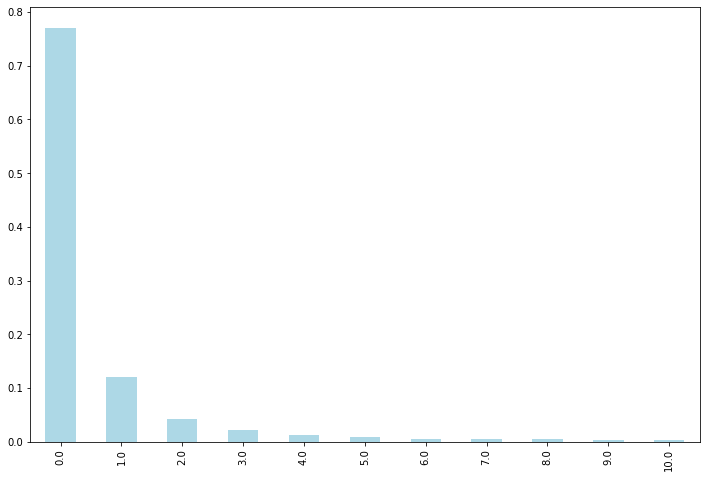

In [32]:
# Graph above value counts
test2 = test[test['scoring_days_diff']<=10]
fig, ax = plt.subplots(figsize=(12,8))
print(test2['scoring_days_diff'].value_counts(sort=False
                                             ,normalize=True).sort_values(ascending=False).plot(ax=ax
                                                                                                , kind='bar'
                                                                                                ,color='lightblue'))

AxesSubplot(0.125,0.125;0.775x0.755)


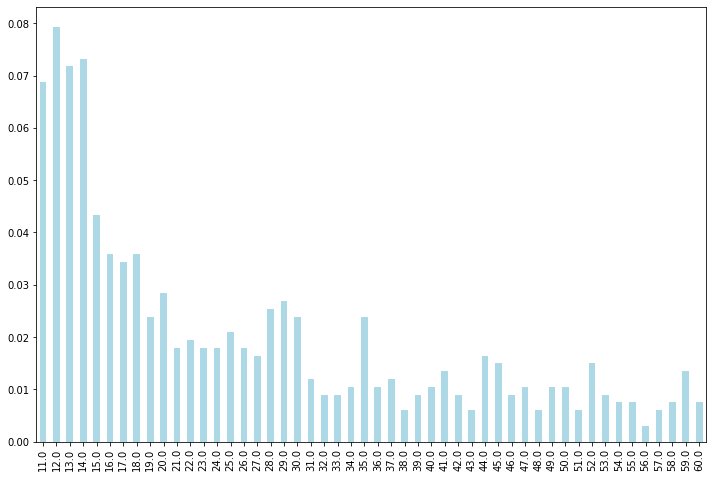

In [50]:
# Graph above value counts

test3 = test[(test.scoring_days_diff>10) & (test.scoring_days_diff<61)]
fig, ax = plt.subplots(figsize=(12,8))
print(test3['scoring_days_diff'].value_counts(sort=False
                                              ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                               , kind='bar'
                                                                                               ,color='lightblue'))

AxesSubplot(0.125,0.125;0.775x0.755)


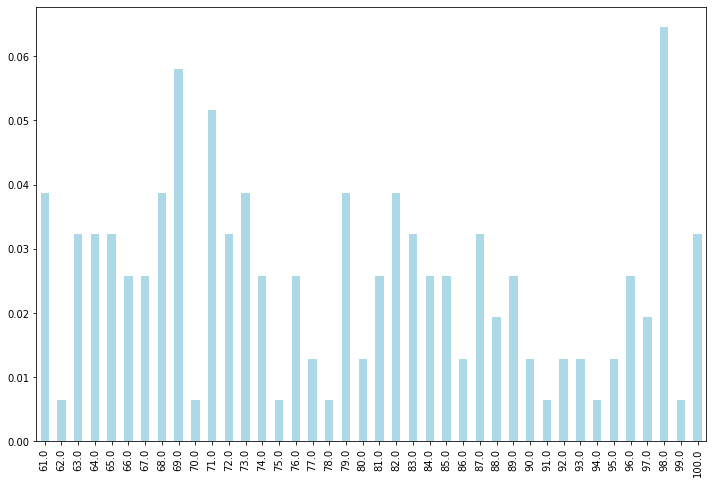

In [51]:
# Graph add above value counts

test4 = test[(test.scoring_days_diff>60) & (test.scoring_days_diff<101)]
fig, ax = plt.subplots(figsize=(12,8))
print(test4['scoring_days_diff'].value_counts(sort=False
                                              ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                               , kind='bar'
                                                                                               ,color='lightblue'))

AxesSubplot(0.125,0.125;0.775x0.755)


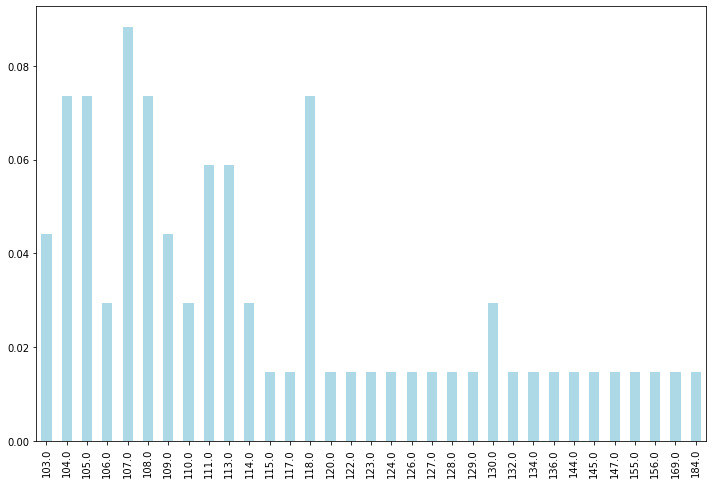

In [52]:
# Graph add above value counts

test5 = test[(test.scoring_days_diff>101)]
fig, ax = plt.subplots(figsize=(12,8))
print(test5['scoring_days_diff'].value_counts(sort=False
                                              ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                               , kind='bar'
                                                                                               ,color='lightblue'))

In [22]:
print('Full data has ' + str(SRP_CMT_Heartbeat['short_user_id'].nunique()) + ' unique drivers.')

Full data has 14148 unique drivers.


In [23]:
# Check to make sure no Max_Last_request_date > Max_final_score_date
# After 4/08/2021, check NM1_registration_date > Max_final_score_date - N/A
print(SRP_CMT_Heartbeat.Max_Last_request_date.value_counts().sort_index())
SRP_CMT_Heartbeat.Max_final_score_date.value_counts().sort_index()

2020-06-12      1
2020-06-15      1
2020-06-16      1
2020-06-17      2
2020-06-18      3
             ... 
2021-02-27      2
2021-02-28     22
2021-03-01     90
2021-03-02    272
2021-03-03    119
Name: Max_Last_request_date, Length: 250, dtype: int64


2020-08-11      2
2020-08-12      2
2020-08-13      2
2020-08-14      1
2020-08-17      1
             ... 
2021-02-26    118
2021-03-01     92
2021-03-02    339
2021-03-03    100
2021-03-04    136
Name: Max_final_score_date, Length: 134, dtype: int64

In [39]:
# Calculate annual distance
df = SRP_CMT_Heartbeat

# Derive Exp_Year, lEpr, avg_ann_adj_KM_pu, log_avg_ann_adj_KM_pu
# Check the max cutoff km
scoring_data = (df.assign(Exp_Year=lambda df: df.scoring_days/365
                          ,lEpr=lambda df: np.log(df.Exp_Year)
                          ,avg_ann_adj_KM_pu=lambda df: df.adjusted_distance_km/df.Exp_Year
                          ,log_avg_ann_adj_KM_pu=lambda df: np.where(df.avg_ann_adj_KM_pu < 100000
                                                                     ,np.log(df.avg_ann_adj_KM_pu)
                                                                     , np.log(100000)))
                )
print(scoring_data.shape) # 14867 drivers -> now 14822 (3/10/2021) -> now 14819 (3/11/2021) -> now 14148 (3/15/2021)
scoring_data.head()

(14148, 19)


,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,Max_Last_request_date,NM1_registration_date,Max_Date,scoring_days,NM1_active_days,Exp_Year,lEpr,avg_ann_adj_KM_pu,log_avg_ann_adj_KM_pu
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,2021-01-05,2020-09-04,2021-01-05,140.0,123.0,0.383562,-0.958255,690.058832,6.536777
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,2020-12-15,2020-08-04,2020-12-15,139.0,133.0,0.380822,-0.965423,25260.730935,10.137006
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,2020-11-08,2020-07-10,2020-11-08,122.0,120.0,0.334247,-1.095876,19312.904234,9.868529
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,2020-11-08,2020-08-28,2020-11-08,73.0,72.0,0.200000,-1.609438,16000.840000,9.680396
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,2020-12-30,2020-08-18,2020-12-30,136.0,134.0,0.372603,-0.987242,23846.504474,10.079393


In [40]:
# Additionally, calculate using NM1_active_days

df = scoring_data

# Derive Exp_Year, lEpr, avg_ann_adj_KM_pu, log_avg_ann_adj_KM_pu
# Check the max cutoff km
scoring_data2 = (df.assign(NM1_Exp_Year=lambda df: df.NM1_active_days/365
                          ,NM1_lEpr=lambda df: np.log(df.NM1_Exp_Year)
                          ,NM1_avg_ann_adj_KM_pu=lambda df: df.adjusted_distance_km/df.NM1_Exp_Year
                          ,NM1_log_avg_ann_adj_KM_pu=lambda df: np.where(df.NM1_avg_ann_adj_KM_pu < 100000
                                                                     ,np.log(df.NM1_avg_ann_adj_KM_pu)
                                                                     , np.log(100000)))
                )
print(scoring_data2.shape) 
scoring_data2.head()

(14148, 23)


,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,scoring_days,NM1_active_days,Exp_Year,lEpr,avg_ann_adj_KM_pu,log_avg_ann_adj_KM_pu,NM1_Exp_Year,NM1_lEpr,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,140.0,123.0,0.383562,-0.958255,690.058832,6.536777,0.336986,-1.087713,785.432817,6.666235
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,139.0,133.0,0.380822,-0.965423,25260.730935,10.137006,0.364384,-1.009548,26400.312782,10.181131
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,122.0,120.0,0.334247,-1.095876,19312.904234,9.868529,0.328767,-1.112406,19634.785971,9.885058
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,73.0,72.0,0.200000,-1.609438,16000.840000,9.680396,0.197260,-1.623231,16223.073889,9.694190
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,136.0,134.0,0.372603,-0.987242,23846.504474,10.079393,0.367123,-1.002058,24202.422451,10.094208


In [41]:
# Calculate model score for NM2
scoring_data2['NM2_predicted'] = np.exp(-8.424102581326078 
                                   + 0.4349686611968898 * scoring_data2['log_avg_ann_adj_KM_pu'] 
                                   + 0.42507261958851317 * scoring_data2['Rq5a'])
scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM1_active_days,Exp_Year,lEpr,avg_ann_adj_KM_pu,log_avg_ann_adj_KM_pu,NM1_Exp_Year,NM1_lEpr,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu,NM2_predicted
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,123.0,0.383562,-0.958255,690.058832,6.536777,0.336986,-1.087713,785.432817,6.666235,0.025270
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,133.0,0.380822,-0.965423,25260.730935,10.137006,0.364384,-1.009548,26400.312782,10.181131,0.057512
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,120.0,0.334247,-1.095876,19312.904234,9.868529,0.328767,-1.112406,19634.785971,9.885058,0.100156
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,72.0,0.200000,-1.609438,16000.840000,9.680396,0.197260,-1.623231,16223.073889,9.694190,0.085094
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,134.0,0.372603,-0.987242,23846.504474,10.079393,0.367123,-1.002058,24202.422451,10.094208,0.103046


In [42]:
# Calculate model score for NM1
scoring_data2['NM1_predicted'] = np.exp(-8.424102581326078 
                                   + 0.4349686611968898 * scoring_data2['NM1_log_avg_ann_adj_KM_pu'] 
                                   + 0.42507261958851317 * scoring_data2['Rq5a'])
scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,Exp_Year,lEpr,avg_ann_adj_KM_pu,log_avg_ann_adj_KM_pu,NM1_Exp_Year,NM1_lEpr,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu,NM2_predicted,NM1_predicted
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,0.383562,-0.958255,690.058832,6.536777,0.336986,-1.087713,785.432817,6.666235,0.025270,0.026734
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,0.380822,-0.965423,25260.730935,10.137006,0.364384,-1.009548,26400.312782,10.181131,0.057512,0.058626
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,0.334247,-1.095876,19312.904234,9.868529,0.328767,-1.112406,19634.785971,9.885058,0.100156,0.100878
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,0.200000,-1.609438,16000.840000,9.680396,0.197260,-1.623231,16223.073889,9.694190,0.085094,0.085606
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,0.372603,-0.987242,23846.504474,10.079393,0.367123,-1.002058,24202.422451,10.094208,0.103046,0.103712


In [43]:
print(scoring_data2.NM2_predicted.describe(percentiles=[.05,.25,.5,.75,.95,.995]))
print(scoring_data2.NM1_predicted.describe(percentiles=[.05,.25,.5,.75,.95,.995]))

count    14148.000000
mean         0.082241
std          0.038247
min          0.000936
5%           0.031906
25%          0.056810
50%          0.076911
75%          0.101037
95%          0.147393
99.5%        0.234617
max          0.679304
Name: NM2_predicted, dtype: float64
count    14148.000000
mean         0.087816
std          0.040096
min          0.001179
5%           0.037359
25%          0.061814
50%          0.081935
75%          0.106636
95%          0.156870
99.5%        0.248048
max          0.690297
Name: NM1_predicted, dtype: float64


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


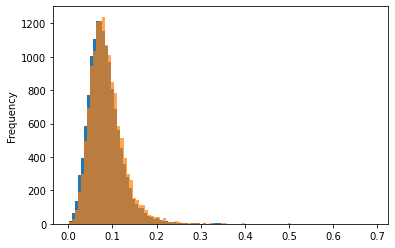

In [44]:
# Look at distribution of scores 
print(scoring_data2['NM2_predicted'].plot.hist(bins=100))
print(scoring_data2['NM1_predicted'].plot.hist(alpha=0.7,bins=100))

In [45]:
# Reshape model score to final score for NM2
scoring_data2['NM2_Mapped_Score'] = scoring_data2['NM2_predicted']
scoring_data2['NM2_Mapped_Score'] = scoring_data2.NM2_Mapped_Score.apply(lambda x: np.floor((np.maximum(np.minimum(x,0.26506423)
                                                                                                        , 0.01695606)
                                                                                             -0.01695606)*4006.31708339)+1)
scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,lEpr,avg_ann_adj_KM_pu,log_avg_ann_adj_KM_pu,NM1_Exp_Year,NM1_lEpr,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu,NM2_predicted,NM1_predicted,NM2_Mapped_Score
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,-0.958255,690.058832,6.536777,0.336986,-1.087713,785.432817,6.666235,0.025270,0.026734,34.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,-0.965423,25260.730935,10.137006,0.364384,-1.009548,26400.312782,10.181131,0.057512,0.058626,163.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,-1.095876,19312.904234,9.868529,0.328767,-1.112406,19634.785971,9.885058,0.100156,0.100878,334.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,-1.609438,16000.840000,9.680396,0.197260,-1.623231,16223.073889,9.694190,0.085094,0.085606,273.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,-0.987242,23846.504474,10.079393,0.367123,-1.002058,24202.422451,10.094208,0.103046,0.103712,345.0


In [46]:
# Reshape model score to final score for NM1
scoring_data2['NM1_Mapped_Score'] = scoring_data2['NM1_predicted']
scoring_data2['NM1_Mapped_Score'] = scoring_data2.NM1_Mapped_Score.apply(lambda x: np.floor((np.maximum(np.minimum(x,0.26506423)
                                                                                                        , 0.01695606)
                                                                                             -0.01695606)*4006.31708339)+1)
scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,avg_ann_adj_KM_pu,log_avg_ann_adj_KM_pu,NM1_Exp_Year,NM1_lEpr,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu,NM2_predicted,NM1_predicted,NM2_Mapped_Score,NM1_Mapped_Score
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,690.058832,6.536777,0.336986,-1.087713,785.432817,6.666235,0.025270,0.026734,34.0,40.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,25260.730935,10.137006,0.364384,-1.009548,26400.312782,10.181131,0.057512,0.058626,163.0,167.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,19312.904234,9.868529,0.328767,-1.112406,19634.785971,9.885058,0.100156,0.100878,334.0,337.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,16000.840000,9.680396,0.197260,-1.623231,16223.073889,9.694190,0.085094,0.085606,273.0,276.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,23846.504474,10.079393,0.367123,-1.002058,24202.422451,10.094208,0.103046,0.103712,345.0,348.0


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


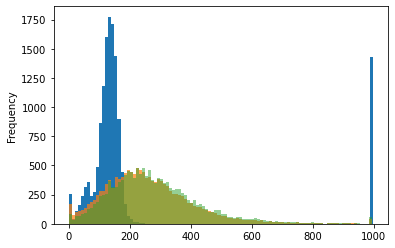

In [47]:
# Look at distribution of final scores 
print(scoring_data2['NM1_score_qt'].plot.hist(bins=100)) # BLUE
print(scoring_data2['NM2_Mapped_Score'].plot.hist(alpha=0.7,bins=100)) # ORANGE
print(scoring_data2['NM1_Mapped_Score'].plot.hist(alpha=0.5,bins=100)) # GREEN

In [48]:
# Calculate NM2 rscore
#rscore is the current discount factor based on the pure score
scoring_data2['NM2_rscore']=scoring_data2.NM2_Mapped_Score.apply(lambda x: 0.53 if x<=98 else
                                                    0.54 if x<=141 else
                                                    0.57 if x<=170 else
                                                    0.60 if x<=193 else
                                                    0.64 if x<=215 else
                                                    0.67 if x<=234 else
                                                    0.70 if x<=252 else
                                                    0.71 if x<=269 else
                                                    0.72 if x<=286 else
                                                    0.73 if x<=303 else
                                                    0.74 if x<=321 else
                                                    0.76 if x<=339 else
                                                    0.79 if x<=358 else
                                                    0.82 if x<=379 else
                                                    0.85 if x<=403 else
                                                    0.88 if x<=432 else
                                                    0.91 if x<=470 else
                                                    0.94 if x<=521 else
                                                    0.97 if x<=612 else
                                                    1.0)
# Format to be percent discount
scoring_data2['NM2_discount_pc'] = (1-scoring_data2['NM2_rscore'])*100

scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM1_Exp_Year,NM1_lEpr,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu,NM2_predicted,NM1_predicted,NM2_Mapped_Score,NM1_Mapped_Score,NM2_rscore,NM2_discount_pc
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,0.336986,-1.087713,785.432817,6.666235,0.025270,0.026734,34.0,40.0,0.53,47.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,0.364384,-1.009548,26400.312782,10.181131,0.057512,0.058626,163.0,167.0,0.57,43.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,0.328767,-1.112406,19634.785971,9.885058,0.100156,0.100878,334.0,337.0,0.76,24.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,0.197260,-1.623231,16223.073889,9.694190,0.085094,0.085606,273.0,276.0,0.72,28.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,0.367123,-1.002058,24202.422451,10.094208,0.103046,0.103712,345.0,348.0,0.79,21.0


In [49]:
# Calculate NM1 rscore
scoring_data2['NM1_rscore']=scoring_data2.NM1_Mapped_Score.apply(lambda x: 0.53 if x<=98 else
                                                    0.54 if x<=141 else
                                                    0.57 if x<=170 else
                                                    0.60 if x<=193 else
                                                    0.64 if x<=215 else
                                                    0.67 if x<=234 else
                                                    0.70 if x<=252 else
                                                    0.71 if x<=269 else
                                                    0.72 if x<=286 else
                                                    0.73 if x<=303 else
                                                    0.74 if x<=321 else
                                                    0.76 if x<=339 else
                                                    0.79 if x<=358 else
                                                    0.82 if x<=379 else
                                                    0.85 if x<=403 else
                                                    0.88 if x<=432 else
                                                    0.91 if x<=470 else
                                                    0.94 if x<=521 else
                                                    0.97 if x<=612 else
                                                    1.0)
# Format to be percent discount
scoring_data2['NM1_discount_pc2'] = (1-scoring_data2['NM1_rscore'])*100

scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM1_avg_ann_adj_KM_pu,NM1_log_avg_ann_adj_KM_pu,NM2_predicted,NM1_predicted,NM2_Mapped_Score,NM1_Mapped_Score,NM2_rscore,NM2_discount_pc,NM1_rscore,NM1_discount_pc2
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,785.432817,6.666235,0.025270,0.026734,34.0,40.0,0.53,47.0,0.53,47.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,26400.312782,10.181131,0.057512,0.058626,163.0,167.0,0.57,43.0,0.57,43.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,19634.785971,9.885058,0.100156,0.100878,334.0,337.0,0.76,24.0,0.76,24.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,16223.073889,9.694190,0.085094,0.085606,273.0,276.0,0.72,28.0,0.72,28.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,24202.422451,10.094208,0.103046,0.103712,345.0,348.0,0.79,21.0,0.79,21.0


In [50]:
print(scoring_data2.NM2_discount_pc.describe(percentiles=[.05,.25,.5,.75,.95,.995]))
print(scoring_data2.NM1_discount_pc2.describe(percentiles=[.05,.25,.5,.75,.95,.995]))
print(scoring_data2.NM1_discount_pc.describe(percentiles=[.05,.25,.5,.75,.95,.995]))
scoring_data2['NM1_discount_pc3'] = scoring_data2['NM1_discount_pc']/.8
print(scoring_data2.NM1_discount_pc3.describe(percentiles=[.05,.25,.5,.75,.95,.995]))

count    14148.000000
mean        30.342098
std         13.322625
min          0.000000
5%           3.000000
25%         24.000000
50%         30.000000
75%         43.000000
95%         47.000000
99.5%       47.000000
max         47.000000
Name: NM2_discount_pc, dtype: float64
count    14148.000000
mean        28.420837
std         13.542840
min          0.000000
5%           3.000000
25%         18.000000
50%         29.000000
75%         40.000000
95%         47.000000
99.5%       47.000000
max         47.000000
Name: NM1_discount_pc2, dtype: float64
count    14141.000000
mean        24.321547
std         10.990838
min          0.000000
5%           0.000000
25%         21.000000
50%         28.000000
75%         31.000000
95%         40.000000
99.5%       40.000000
max         40.000000
Name: NM1_discount_pc, dtype: float64
count    14141.000000
mean        30.401934
std         13.738547
min          0.000000
5%           0.000000
25%         26.250000
50%         35.000000
75%  

AxesSubplot(0.125,0.125;0.775x0.755)


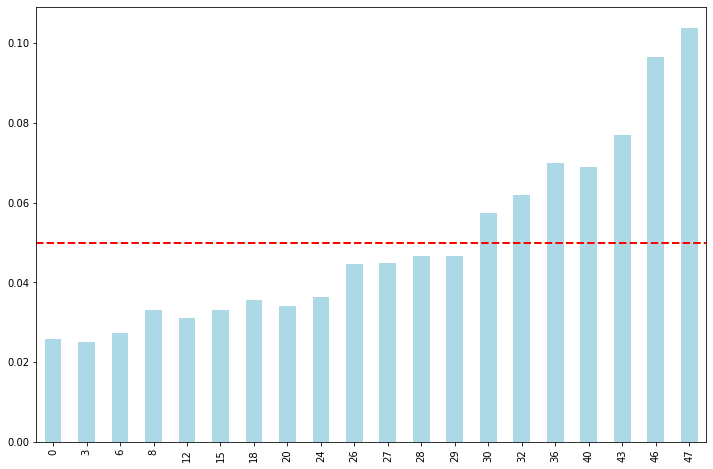

In [51]:
scoring_data2['NM2_discount_pc'] = scoring_data2['NM2_discount_pc'].astype(np.int64)

fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['NM2_discount_pc'].value_counts(sort=False
                                                    ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                                     , kind='bar'
                                                                                                    ,color='lightblue'))
ax.axhline(y=0.05, xmin=0, xmax=1, color='r', linestyle='--', lw=2)

AxesSubplot(0.125,0.125;0.775x0.755)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


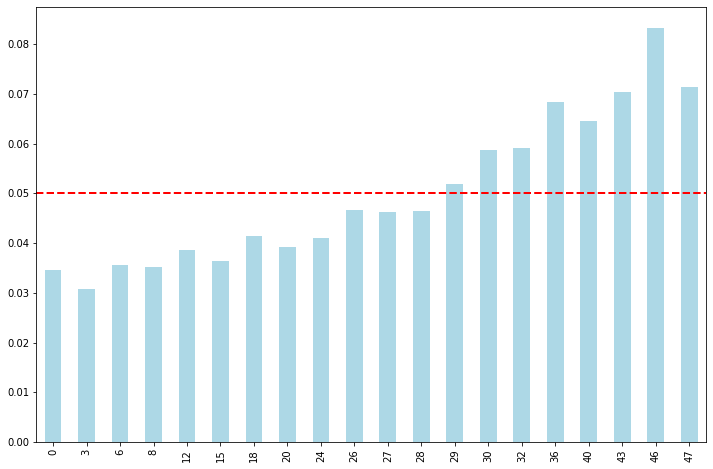

In [52]:
test = scoring_data2.dropna()
test['NM1_discount_pc2'] = test['NM1_discount_pc2'].astype(np.int64)

fig, ax = plt.subplots(figsize=(12,8))
print(test['NM1_discount_pc2'].value_counts(sort=False
                                                    ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                                     , kind='bar'
                                                                                                    ,color='lightblue'))
ax.axhline(y=0.05, xmin=0, xmax=1, color='r', linestyle='--', lw=2)

In [53]:
# Calculate new min / max bounds
scoring_data2.NM2_predicted.quantile([.005, .995])
# 0.005    0.013551
# 0.995    0.231314

# FINAL - 3/15/2021
# 0.005    0.013552
# 0.995    0.234617

0.005    0.013552
0.995    0.234617
Name: NM2_predicted, dtype: float64

In [54]:
LB=0.013552
UB=0.234617
SCALE=994/(UB-LB)
print(LB)
print(UB)
SCALE

0.013552
0.234617


4496.415081537105

In [55]:
scoring_data2['NM2_CMT_Score']=scoring_data2.NM2_predicted.apply(lambda x: np.floor((np.maximum(np.minimum(x,UB)
                                                                                                , LB)-LB)*SCALE)+1)
scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM2_predicted,NM1_predicted,NM2_Mapped_Score,NM1_Mapped_Score,NM2_rscore,NM2_discount_pc,NM1_rscore,NM1_discount_pc2,NM1_discount_pc3,NM2_CMT_Score
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,0.025270,0.026734,34.0,40.0,0.53,47,0.53,47.0,0.00,53.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,0.057512,0.058626,163.0,167.0,0.57,43,0.57,43.0,36.25,198.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,0.100156,0.100878,334.0,337.0,0.76,24,0.76,24.0,36.25,390.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,0.085094,0.085606,273.0,276.0,0.72,28,0.72,28.0,0.00,322.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,0.103046,0.103712,345.0,348.0,0.79,20,0.79,21.0,26.25,403.0


In [56]:
# Calculate NM2 CMT rscore 
scoring_data2['NM2_CMT_rscore']=scoring_data2.NM2_CMT_Score.apply(lambda x: 0.53 if x<=98 else
                                                    0.54 if x<=141 else
                                                    0.57 if x<=170 else
                                                    0.60 if x<=193 else
                                                    0.64 if x<=215 else
                                                    0.67 if x<=234 else
                                                    0.70 if x<=252 else
                                                    0.71 if x<=269 else
                                                    0.72 if x<=286 else
                                                    0.73 if x<=303 else
                                                    0.74 if x<=321 else
                                                    0.76 if x<=339 else
                                                    0.79 if x<=358 else
                                                    0.82 if x<=379 else
                                                    0.85 if x<=403 else
                                                    0.88 if x<=432 else
                                                    0.91 if x<=470 else
                                                    0.94 if x<=521 else
                                                    0.97 if x<=612 else
                                                    1.0)
# Format to be percent discount
scoring_data2['NM2_CMT_discount_pc'] = (1-scoring_data2['NM2_CMT_rscore'])*100

scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM2_Mapped_Score,NM1_Mapped_Score,NM2_rscore,NM2_discount_pc,NM1_rscore,NM1_discount_pc2,NM1_discount_pc3,NM2_CMT_Score,NM2_CMT_rscore,NM2_CMT_discount_pc
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,34.0,40.0,0.53,47,0.53,47.0,0.00,53.0,0.53,47.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,163.0,167.0,0.57,43,0.57,43.0,36.25,198.0,0.64,36.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,334.0,337.0,0.76,24,0.76,24.0,36.25,390.0,0.85,15.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,273.0,276.0,0.72,28,0.72,28.0,0.00,322.0,0.76,24.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,345.0,348.0,0.79,20,0.79,21.0,26.25,403.0,0.85,15.0


In [57]:
print(scoring_data2.NM2_discount_pc.mean())
scoring_data2.NM2_CMT_discount_pc.mean()

30.21282160022618


26.073508623126944

AxesSubplot(0.125,0.125;0.775x0.755)


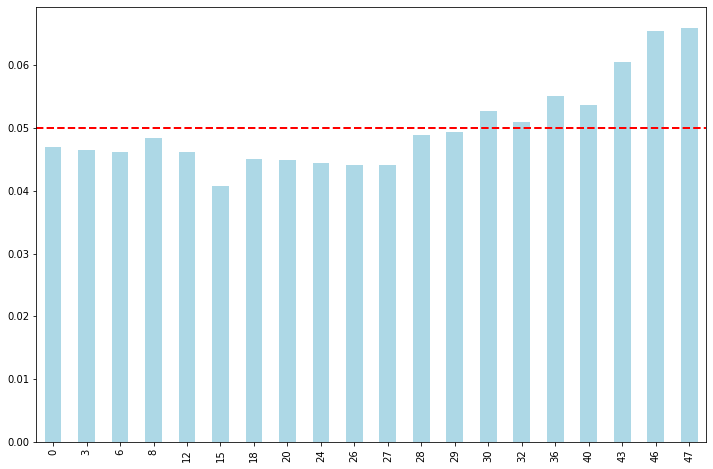

In [58]:
scoring_data2['NM2_CMT_discount_pc'] = scoring_data2['NM2_CMT_discount_pc'].astype(np.int64)
fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['NM2_CMT_discount_pc'].value_counts(sort=False
                                                    ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                                     , kind='bar'
                                                                                                    ,color='lightblue'))
ax.axhline(y=0.05, xmin=0, xmax=1, color='r', linestyle='--', lw=2)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['NM1_discount_pc3'].value_counts(sort=False,normalize=True).sort_index(ascending=True).plot(ax=ax, kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


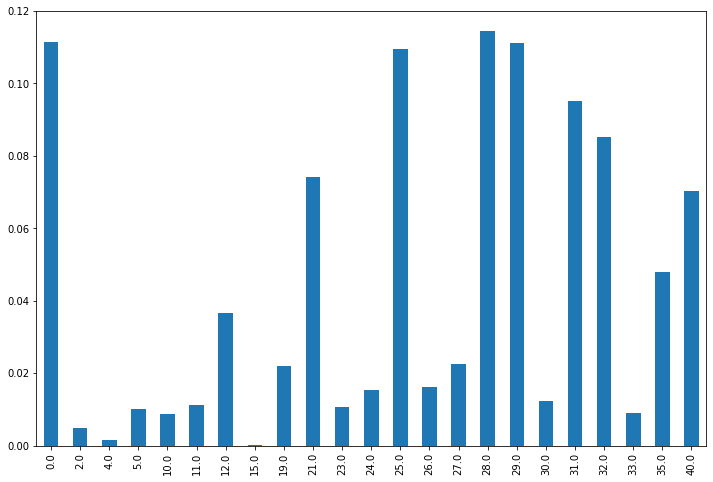

In [75]:
fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['NM1_discount_pc'].value_counts(sort=False,normalize=True).sort_index(ascending=True).plot(ax=ax, kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


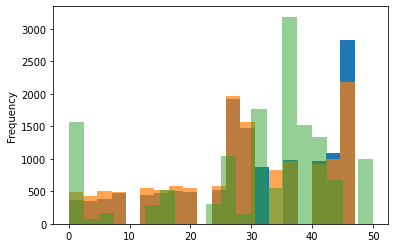

In [76]:
# Look at distribution of rscore
print(scoring_data2['NM2_discount_pc'].plot.hist(bins=20)) # BLUE
print(scoring_data2['NM1_discount_pc2'].plot.hist(alpha=0.7,bins=20)) # ORANGE
print(scoring_data2['NM1_discount_pc3'].plot.hist(alpha=0.5,bins=20)) # GREEN

In [77]:
print(scoring_data2.NM1_active_days.describe())
scoring_data2.scoring_days.describe()

count    14141.000000
mean       115.615586
std         40.283529
min          1.000000
25%        105.000000
50%        129.000000
75%        136.000000
max        264.000000
Name: NM1_active_days, dtype: float64


count    14141.000000
mean       126.740895
std         36.357128
min          1.000000
25%        121.000000
50%        136.000000
75%        141.000000
max        269.000000
Name: scoring_days, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


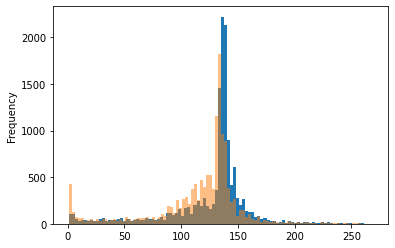

In [78]:
print(scoring_data2['scoring_days'].plot.hist(bins=100)) # BLUE
print(scoring_data2['NM1_active_days'].plot.hist(alpha=0.5,bins=100)) # ORANGE

In [51]:
# Additional Plots

plt_df = (scoring_data2.NM2_discount_pc.value_counts()
          .rename_axis('NM2_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (scoring_data2.NM2_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_discount_pc'), on = 'NM2_discount_pc')

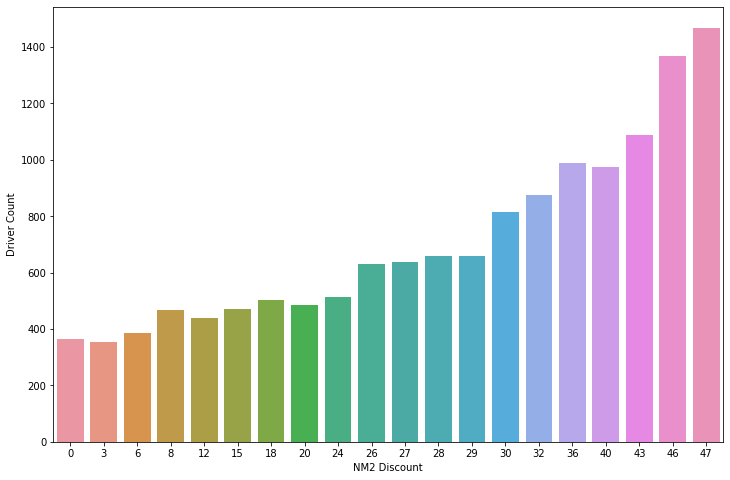

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 Discount', ylabel='Driver Count')

plt.show()

In [53]:
# Additional Plots

plt_df = (scoring_data2.NM1_discount_pc2.value_counts()
          .rename_axis('NM1_discount_pc2')
          .reset_index(name = 'count')
         )
 
plt_df2 = (scoring_data2.NM1_discount_pc2.value_counts(normalize = True)
           .rename_axis('NM1_discount_pc2')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM1_discount_pc2'), on = 'NM1_discount_pc2')

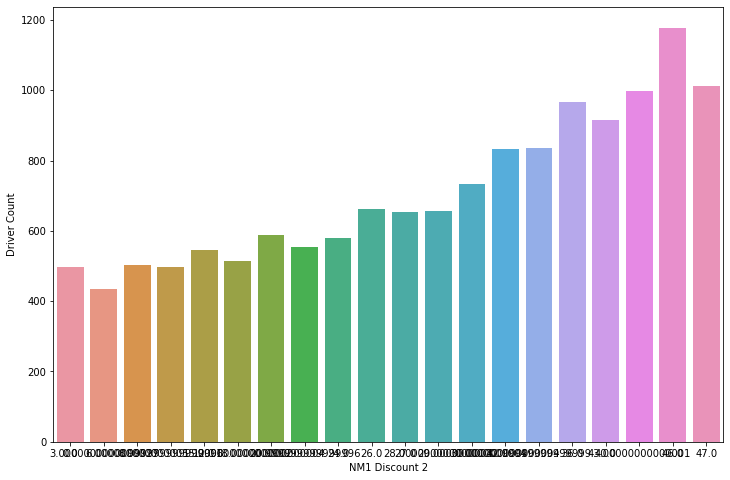

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM1_discount_pc2", y = "count", data = plt_df3)
ax.set(xlabel='NM1 Discount 2', ylabel='Driver Count')

plt.show()

In [55]:
# 1 - Get the short_user_id from SRM data who has 998, and look at our discount, # of drivers
test = scoring_data2[scoring_data2['NM1_score_qt']==998]
print(test.NM2_discount_pc.describe())
print(test.NM1_discount_pc2.describe())
print(test.NM1_discount_pc.describe())
test.shape
# of drivers = 1,270 out of total 14,148

count    1270.000000
mean       33.570866
std        13.881666
min         0.000000
25%        26.000000
50%        36.000000
75%        46.000000
max        47.000000
Name: NM2_discount_pc, dtype: float64
count    1270.000000
mean       25.318110
std        14.671058
min         0.000000
25%        12.000000
50%        27.000000
75%        36.000000
max        47.000000
Name: NM1_discount_pc2, dtype: float64
count    1270.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: NM1_discount_pc, dtype: float64


(1270, 35)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


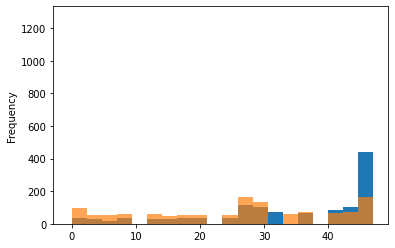

In [56]:
print(test['NM2_discount_pc'].plot.hist(bins=20)) # Blue
print(test['NM1_discount_pc2'].plot.hist(alpha=0.7,bins=20)) # Orange
print(test['NM1_discount_pc'].plot.hist(bins=20)) # Green

In [57]:
# 2 - remove drivers in 1, and then look at the discount again, calculate avg discount?
test2 = scoring_data2[scoring_data2['NM1_score_qt']!=998]
print(test2.NM2_discount_pc.describe())
print(test2.NM1_discount_pc2.describe())
print(test2.NM1_discount_pc.describe())
test2.shape

count    12878.000000
mean        29.881659
std         13.296645
min          0.000000
25%         24.000000
50%         30.000000
75%         43.000000
max         47.000000
Name: NM2_discount_pc, dtype: float64
count    12878.000000
mean        28.726821
std         13.388157
min          0.000000
25%         21.000000
50%         29.000000
75%         40.000000
max         47.000000
Name: NM1_discount_pc2, dtype: float64
count    12871.000000
mean        26.721389
std          8.281709
min          0.000000
25%         25.000000
50%         28.000000
75%         31.000000
max         40.000000
Name: NM1_discount_pc, dtype: float64


(12878, 35)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


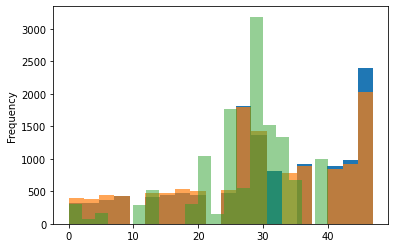

In [58]:
print(test2['NM2_discount_pc'].plot.hist(bins=20)) # Blue
print(test2['NM1_discount_pc2'].plot.hist(alpha=0.7,bins=20)) # Orange
print(test2['NM1_discount_pc'].plot.hist(alpha=0.5,bins=20)) # Green

In [61]:
# Filter to show only drivers in OH
OHIO = scoring_data2[scoring_data2['NM1_rate_state_abbr_nm']=='OH']
print(OHIO.shape)
OHIO.head()

(663, 35)


,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM2_Mapped_Score,NM1_Mapped_Score,NM2_rscore,NM2_discount_pc,NM1_rscore,NM1_discount_pc2,NM1_discount_pc3,NM2_CMT_Score,NM2_CMT_rscore,NM2_CMT_discount_pc
59,10364783,781.5265,4.892132,2020-11-20,2020-11-20,2020-11-10,0.0,0.0,EA,OH,...,518.0,571.0,0.94,6,0.97,3.0,0.00,596.0,0.97,3
70,10436560,3814.2942,4.481212,2021-01-21,2021-01-21,2020-09-04,29.0,129.0,EA,OH,...,256.0,257.0,0.71,29,0.71,29.0,36.25,303.0,0.73,27
135,10845084,1875.6466,4.170404,2020-12-28,2020-12-29,2020-08-11,35.0,64.0,EA,OH,...,140.0,142.0,0.54,46,0.57,43.0,43.75,173.0,0.60,40
141,10876593,9796.4072,3.426443,2021-01-24,2021-01-26,2020-07-03,31.0,123.0,EA,OH,...,195.0,197.0,0.64,36,0.64,36.0,38.75,234.0,0.67,32
154,10946498,10026.5924,3.084890,2020-12-26,2020-12-29,2020-08-11,29.0,128.0,EA,OH,...,204.0,208.0,0.64,36,0.64,36.0,36.25,244.0,0.70,30


In [62]:
(663/14148)*100

4.6861747243426635

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


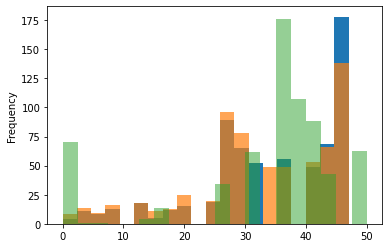

In [63]:
print(OHIO['NM2_discount_pc'].plot.hist(bins=20)) # BLUE
print(OHIO['NM1_discount_pc2'].plot.hist(alpha=0.7,bins=20)) # ORANGE
print(OHIO['NM1_discount_pc3'].plot.hist(alpha=0.5,bins=20)) # GREEN

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


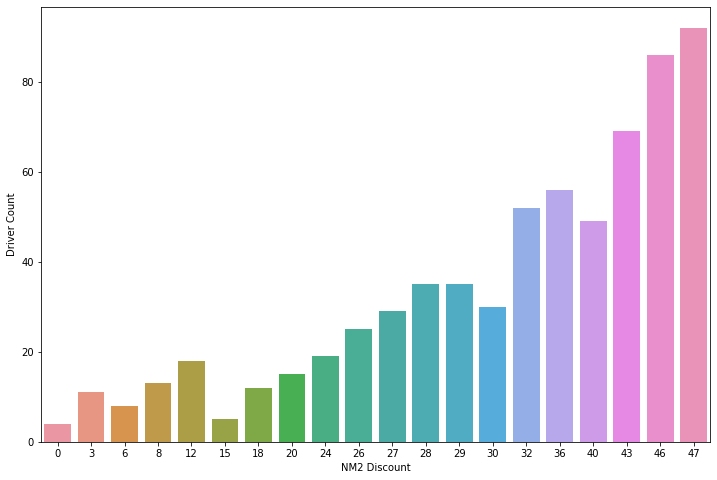

In [64]:
# Ohio plot
OHIO['NM2_discount_pc'] = OHIO['NM2_discount_pc'].astype(np.int64) 

plt_df = (OHIO.NM2_discount_pc.value_counts()
          .rename_axis('NM2_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (OHIO.NM2_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_discount_pc'), on = 'NM2_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 Discount', ylabel='Driver Count')

plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


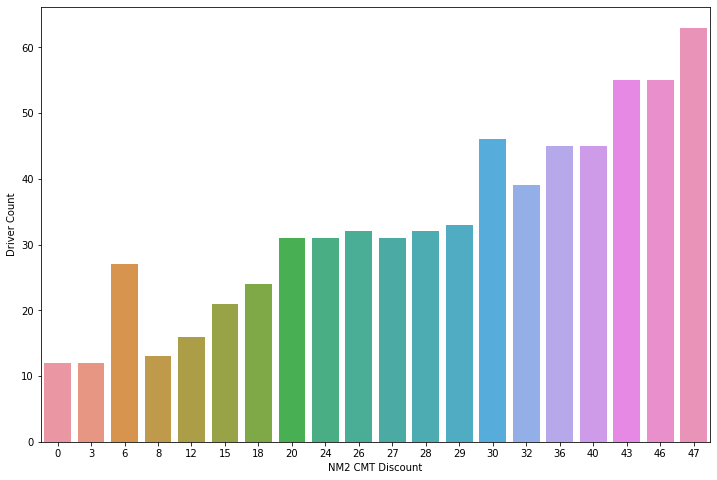

In [65]:
# Ohio plot
OHIO['NM2_CMT_discount_pc'] = OHIO['NM2_CMT_discount_pc'].astype(np.int64) 

plt_df = (OHIO.NM2_CMT_discount_pc.value_counts()
          .rename_axis('NM2_CMT_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (OHIO.NM2_CMT_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_CMT_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_CMT_discount_pc'), on = 'NM2_CMT_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_CMT_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 CMT Discount', ylabel='Driver Count')

plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


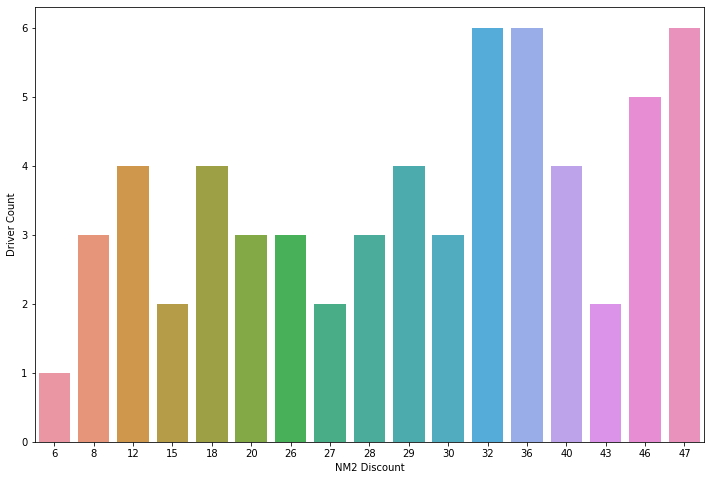

In [67]:
# FL, TX, GA, NY
# Create these plots for states
Florida = scoring_data2[scoring_data2['NM1_rate_state_abbr_nm']=='FL']
Florida['NM2_discount_pc'] = Florida['NM2_discount_pc'].astype(np.int64) 

plt_df = (Florida.NM2_discount_pc.value_counts()
          .rename_axis('NM2_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (Florida.NM2_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_discount_pc'), on = 'NM2_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 Discount', ylabel='Driver Count')

plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(61, 35)


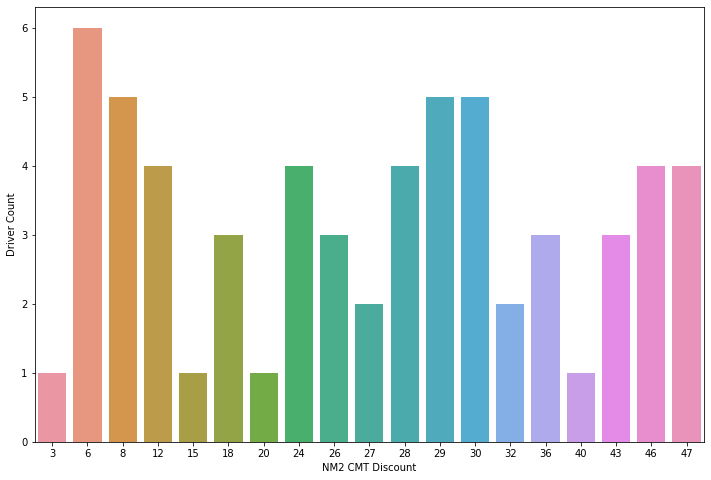

In [72]:
Florida['NM2_CMT_discount_pc'] = Florida['NM2_CMT_discount_pc'].astype(np.int64) 

plt_df = (Florida.NM2_CMT_discount_pc.value_counts()
          .rename_axis('NM2_CMT_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (Florida.NM2_CMT_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_CMT_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_CMT_discount_pc'), on = 'NM2_CMT_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_CMT_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 CMT Discount', ylabel='Driver Count')

print(Florida.shape)
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1240, 35)


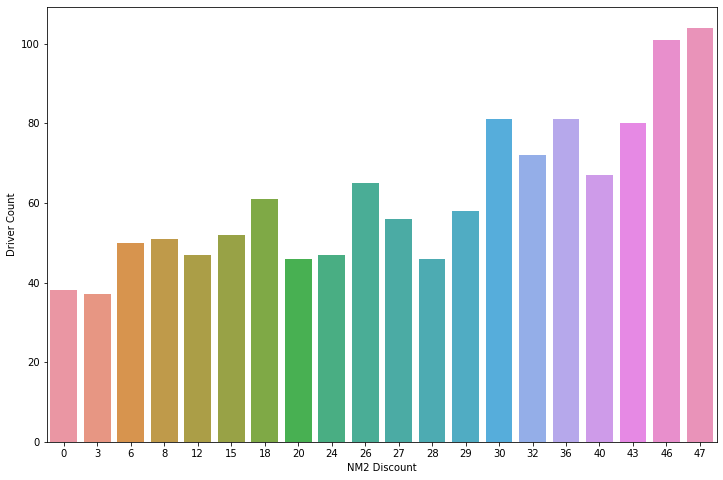

In [70]:
Texas = scoring_data2[scoring_data2['NM1_rate_state_abbr_nm']=='TX']
Texas['NM2_discount_pc'] = Texas['NM2_discount_pc'].astype(np.int64) 

plt_df = (Texas.NM2_discount_pc.value_counts()
          .rename_axis('NM2_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (Texas.NM2_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_discount_pc'), on = 'NM2_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 Discount', ylabel='Driver Count')

print(Texas.shape)
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(602, 35)


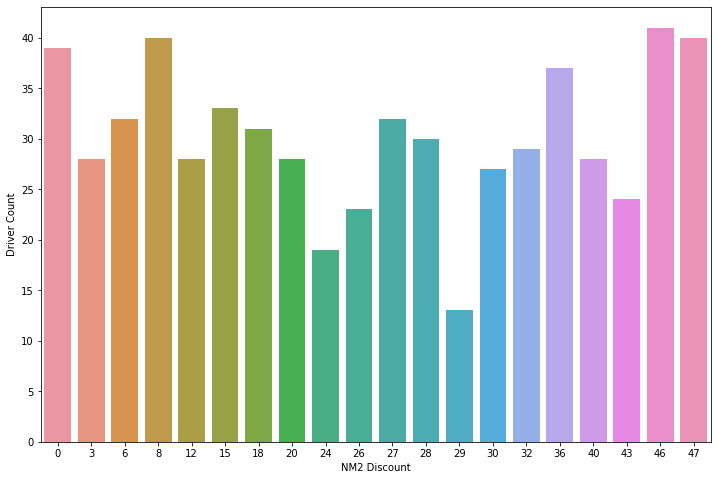

In [71]:
Georgia = scoring_data2[scoring_data2['NM1_rate_state_abbr_nm']=='GA']
Georgia['NM2_discount_pc'] = Georgia['NM2_discount_pc'].astype(np.int64) 

plt_df = (Georgia.NM2_discount_pc.value_counts()
          .rename_axis('NM2_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (Georgia.NM2_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_discount_pc'), on = 'NM2_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 Discount', ylabel='Driver Count')

print(Georgia.shape)
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(602, 35)


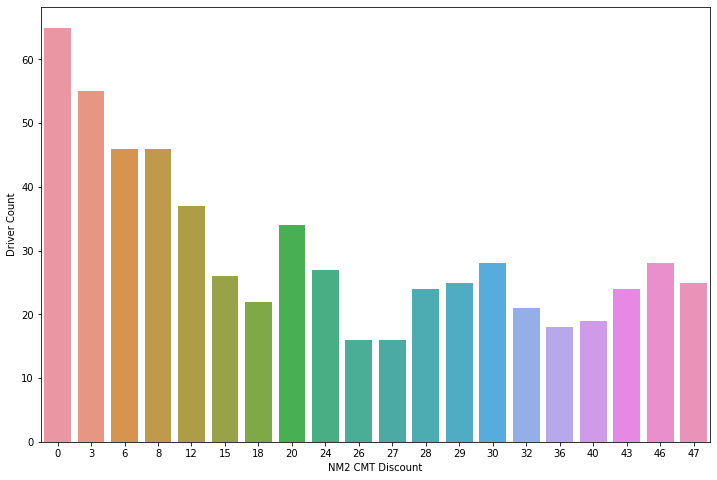

In [73]:
Georgia['NM2_CMT_discount_pc'] = Georgia['NM2_CMT_discount_pc'].astype(np.int64) 

plt_df = (Georgia.NM2_CMT_discount_pc.value_counts()
          .rename_axis('NM2_CMT_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (Georgia.NM2_CMT_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_CMT_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_CMT_discount_pc'), on = 'NM2_CMT_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_CMT_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 CMT Discount', ylabel='Driver Count')

print(Georgia.shape)
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1405, 35)


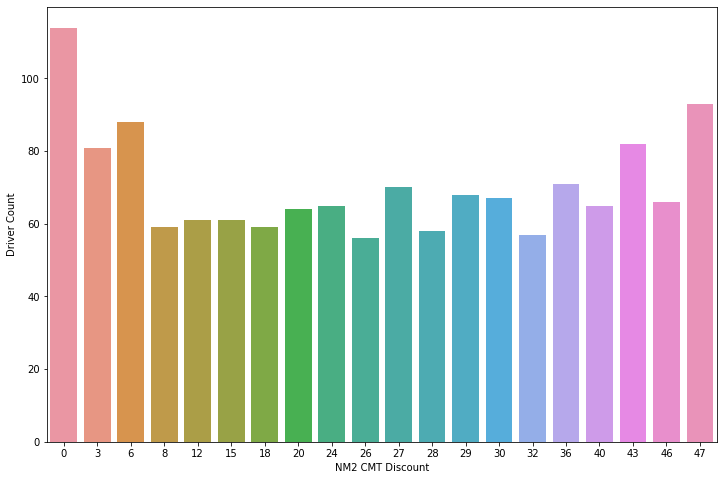

In [74]:
Penn = scoring_data2[scoring_data2['NM1_rate_state_abbr_nm']=='PA']
Penn['NM2_CMT_discount_pc'] = Penn['NM2_CMT_discount_pc'].astype(np.int64) 

plt_df = (Penn.NM2_CMT_discount_pc.value_counts()
          .rename_axis('NM2_CMT_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (Penn.NM2_CMT_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_CMT_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_CMT_discount_pc'), on = 'NM2_CMT_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_CMT_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 CMT Discount', ylabel='Driver Count')

print(Penn.shape)
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


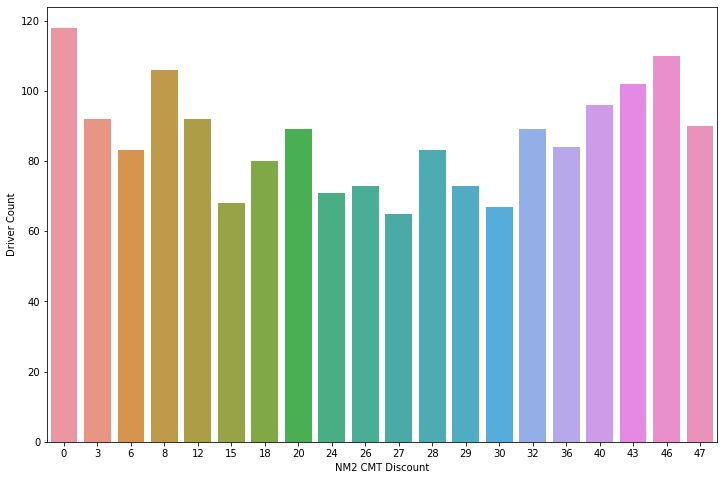

In [75]:
State = scoring_data2[scoring_data2['NM1_rate_state_abbr_nm']=='NC']
State['NM2_CMT_discount_pc'] = State['NM2_CMT_discount_pc'].astype(np.int64) 

plt_df = (State.NM2_CMT_discount_pc.value_counts()
          .rename_axis('NM2_CMT_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (State.NM2_CMT_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_CMT_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_CMT_discount_pc'), on = 'NM2_CMT_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_CMT_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 CMT Discount', ylabel='Driver Count')

plt.show()

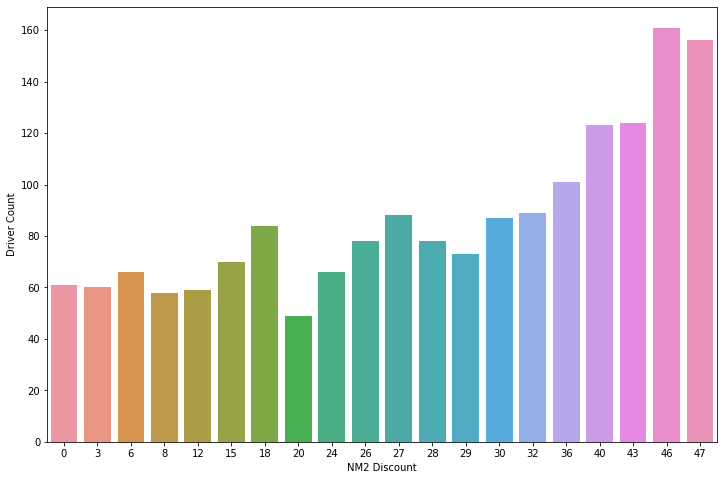

In [76]:
plt_df = (State.NM2_discount_pc.value_counts()
          .rename_axis('NM2_discount_pc')
          .reset_index(name = 'count')
         )
 
plt_df2 = (State.NM2_CMT_discount_pc.value_counts(normalize = True)
           .rename_axis('NM2_discount_pc')
           .reset_index(name = 'percentage')
           .assign(percentage = lambda x: '<b>' + round(x.percentage * 100, 2).astype('str') + '%</b>')
      )
 
plt_df3 = plt_df.merge(plt_df2.set_index('NM2_discount_pc'), on = 'NM2_discount_pc')

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x = "NM2_discount_pc", y = "count", data = plt_df3)
ax.set(xlabel='NM2 Discount', ylabel='Driver Count')

plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


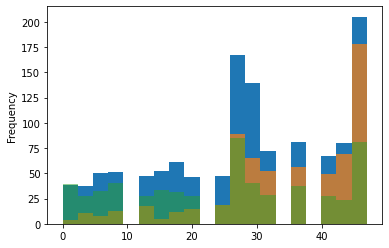

In [77]:
print(Texas['NM2_discount_pc'].plot.hist(bins=20)) # BLUE
print(OHIO['NM2_discount_pc'].plot.hist(alpha=0.7,bins=20)) # ORANGE
print(Georgia['NM2_discount_pc'].plot.hist(alpha=0.5,bins=20)) # GREEN

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


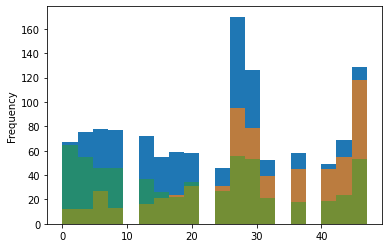

In [78]:
print(Texas['NM2_CMT_discount_pc'].plot.hist(bins=20)) # BLUE
print(OHIO['NM2_CMT_discount_pc'].plot.hist(alpha=0.7,bins=20)) # ORANGE
print(Georgia['NM2_CMT_discount_pc'].plot.hist(alpha=0.5,bins=20)) # GREEN

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


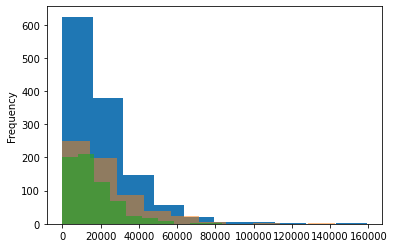

In [81]:
print(Texas['avg_ann_adj_KM_pu'].plot.hist()) # BLUE
print(Georgia['avg_ann_adj_KM_pu'].plot.hist(alpha=0.5)) # ORANGE
print(OHIO['avg_ann_adj_KM_pu'].plot.hist(alpha=0.7)) # GREEN

In [82]:
high_miles = scoring_data2[scoring_data2['avg_ann_adj_KM_pu']>=40000]
high_miles.shape

(1353, 35)

In [83]:
scoring_data2.NM1_rate_state_abbr_nm.value_counts()

NC    1731
PA    1405
TX    1240
CO     973
VA     839
OH     663
GA     602
MD     491
NE     474
IA     429
MN     411
MO     378
KS     346
TN     336
SC     310
IL     298
WA     255
AL     225
NJ     216
WV     215
AR     212
AZ     212
IN     202
MI     190
DE     182
MS     175
KY     131
CT     123
OR     121
SD     112
UT     104
RI      87
NV      73
WI      72
FL      61
MT      39
ID      36
NM      31
VT      30
DC      28
ND      22
NH      21
WY      17
ME      15
OK       8
Name: NM1_rate_state_abbr_nm, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


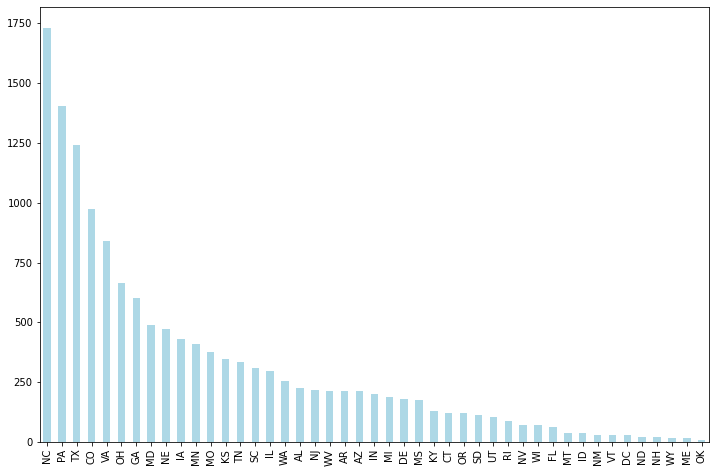

In [84]:
fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['NM1_rate_state_abbr_nm'].value_counts(sort=False).sort_values(ascending=False).plot(ax=ax
                                                                                                     , kind='bar'
                                                                                                    ,color='lightblue'))

In [ ]:
# Save final dataframe
scoring_data2.to_csv('Scoring_Data_3112021.csv', index = False)

# 3/09/2021 @ 5pm - 9am
# score_qt = mapped_score - Done
# score_qt/.8 - Done
# discount_pc = 1-rscore - Done

# 1 - Get the short_user_id from SRM data who has 998, and look at our discount, # of drivers - Done
# 2 - remove drivers in 1, and then look at the discount again, calculate avg discount? - Done 
# 3 - use active_days from SRM data as scoring_days in our NM2 model, recalculate model raw scores, reshaped scores, and rscore.- Done

# Add NM1 in front of each variable - Done
# Remove 80 days filter - Done 
# Change back from load_date to last_request_date - Done
# Keep channel_cd, rate_state_abbr_nm - Done
# Comparing 2 variables dataframe plots - Done

# #6 what would we have if we run drivers in Ohio only since that's the first state to go? 

# Could I get a final graph showing the distribution of these driver scores.  
# I like the bar chart, but I want one with percentage of drivers rather than driver counts by scoring bin.  
# If possible, I'd like a horizontal line at the 5% level to show where the expected distribution.

# Can you do histogram with 100 bins for annulaized adjusted mileage and Rq5a

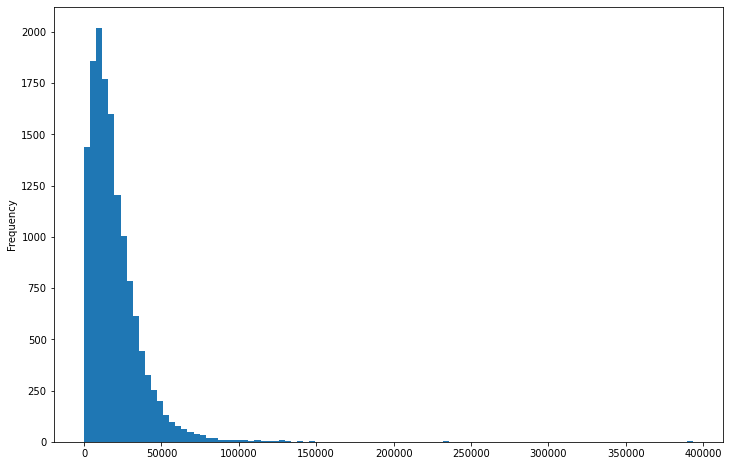

In [51]:
fig = plt.figure(figsize=(12,8))
scoring_data2['avg_ann_adj_KM_pu'].plot.hist(bins=100)

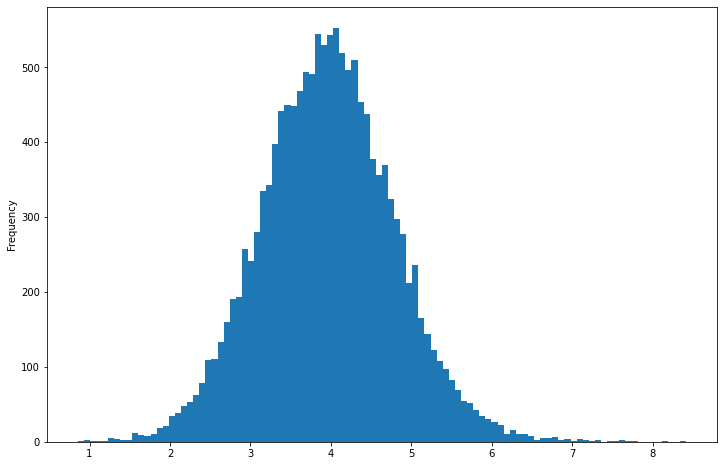

In [52]:
fig = plt.figure(figsize=(12,8))
scoring_data2['Rq5a'].plot.hist(bins=100)

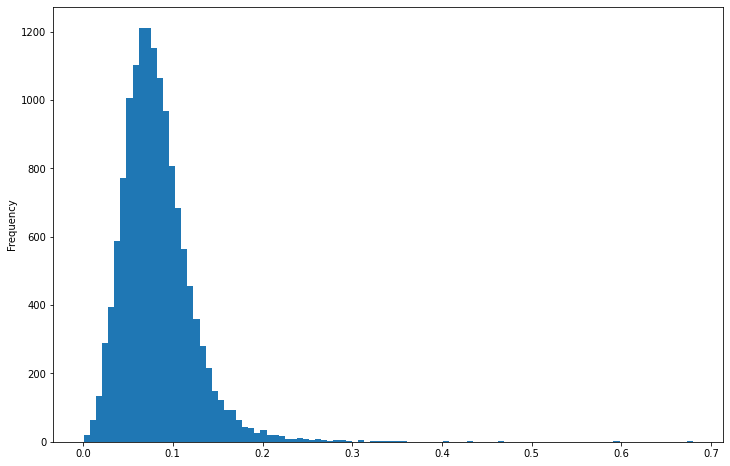

In [53]:
fig = plt.figure(figsize=(12,8))
scoring_data2['NM2_predicted'].plot.hist(bins=100)

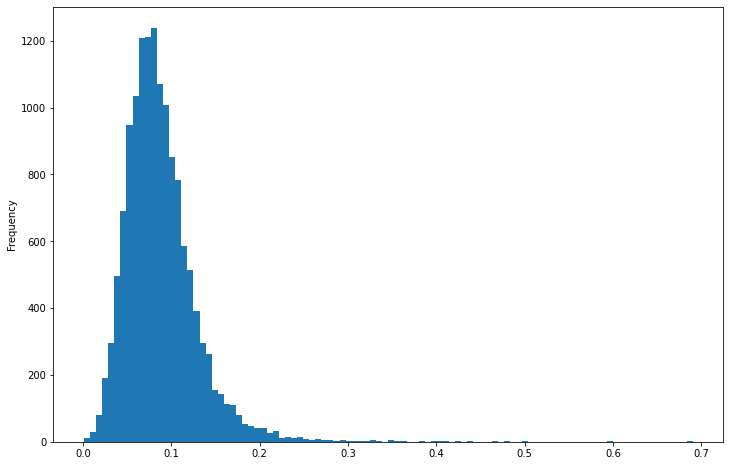

In [121]:
fig = plt.figure(figsize=(12,8))
scoring_data2['NM1_predicted'].plot.hist(bins=100)

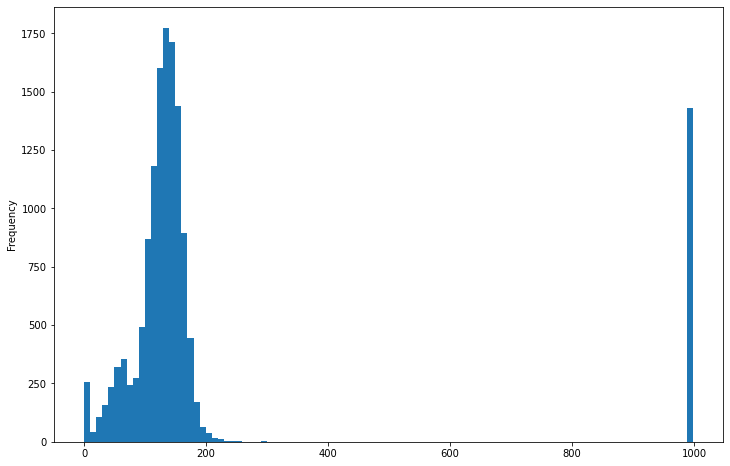

In [122]:
fig = plt.figure(figsize=(12,8))
scoring_data2['NM1_score_qt'].plot.hist(bins=100)

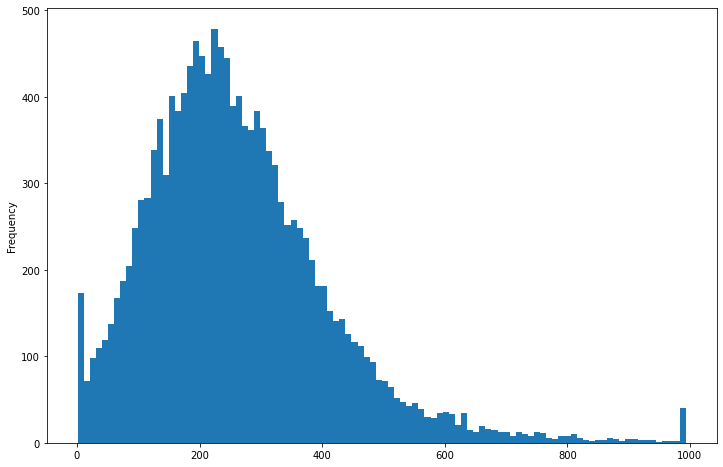

In [124]:
fig = plt.figure(figsize=(12,8))
scoring_data2['NM2_Mapped_Score'].plot.hist(bins=100)

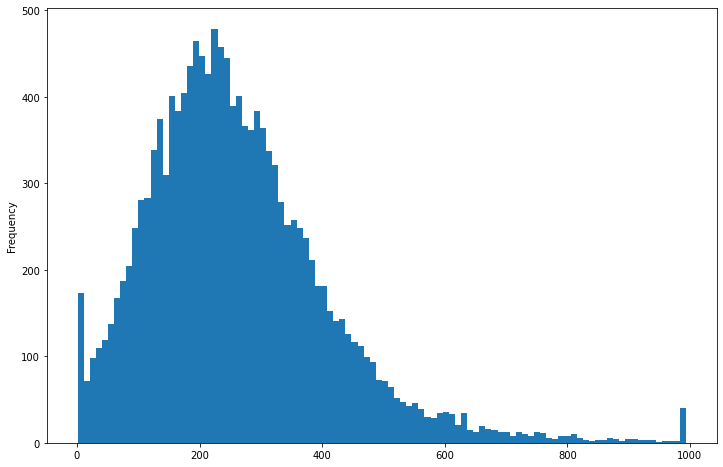

In [88]:
fig = plt.figure(figsize=(12,8))
scoring_data2['NM2_Mapped_Score'].plot.hist(bins=100)

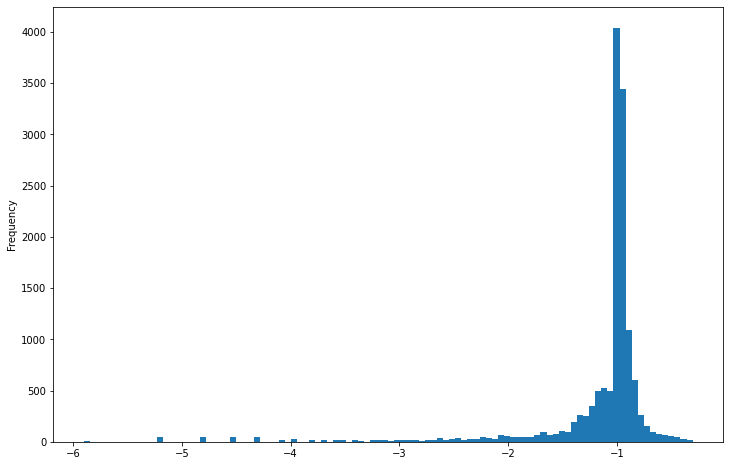

In [114]:
fig = plt.figure(figsize=(12,8))
scoring_data2['lEpr'].plot.hist(bins=100)

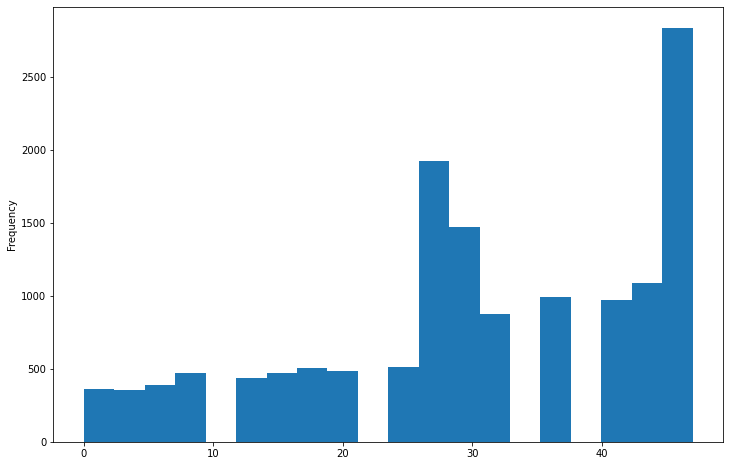

In [89]:
fig = plt.figure(figsize=(12,8))
scoring_data2['NM2_discount_pc'].plot.hist(bins=20)

In [ ]:
# NEW REQUESTS

In [137]:
Mod6 = pd.read_csv("model6_w_pred.csv", low_memory = False)
print(Mod6.shape)
Mod6.head()

(37307, 9)


,policy_nb,ln_telematics_id,active_days,pure_score,avg_ann_adj_KM_pu,Rq5a,mod_6,mod_6_f,Score
0,7701J 056842,803313bf-e264-43c2-b2ec-49c627e6839b,134,166,24659.255992,3.713133,0.031406,0.085546,275.0
1,7701J 057986,ea587dfd-1cfe-4677-a937-dbfc63bb046a,121,200,54159.510175,3.589862,0.038605,0.116454,399.0
2,7701J 039761,9c532e52-439b-46c5-9699-dd0bdb9e3c56,91,117,4812.620446,6.252848,0.031581,0.126670,440.0
3,7701J 055866,b815c3a5-17a0-4180-9919-875bea008152,127,75,3158.192258,4.828008,0.019036,0.054710,152.0
4,7701J 053245,48a9a6b3-f2ef-4f02-9200-d0ee3c1b7fba,152,120,5559.427219,3.743341,0.018122,0.043517,107.0


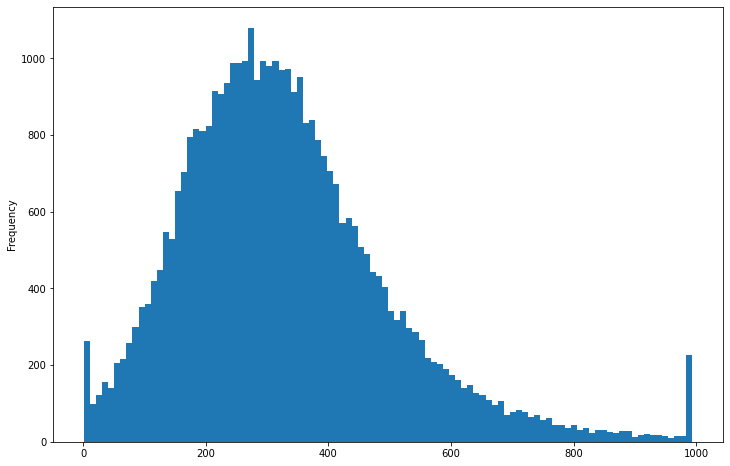

In [138]:
fig = plt.figure(figsize=(12,8))
Mod6['Score'].plot.hist(bins=100)

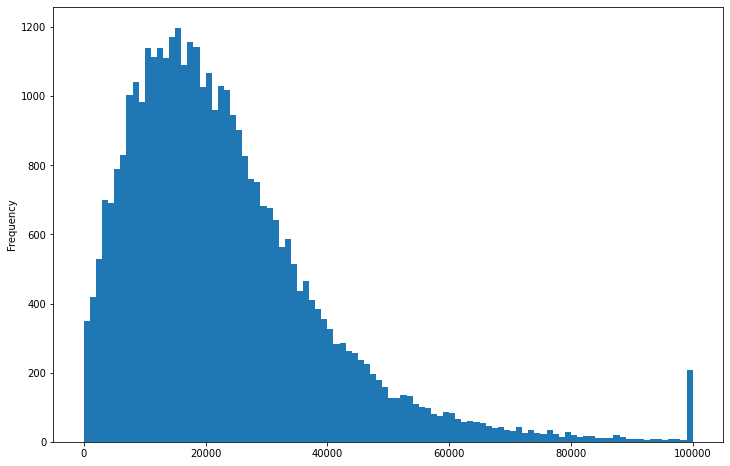

In [93]:
fig = plt.figure(figsize=(12,8))
Mod6['avg_ann_adj_KM_pu'].plot.hist(bins=100)

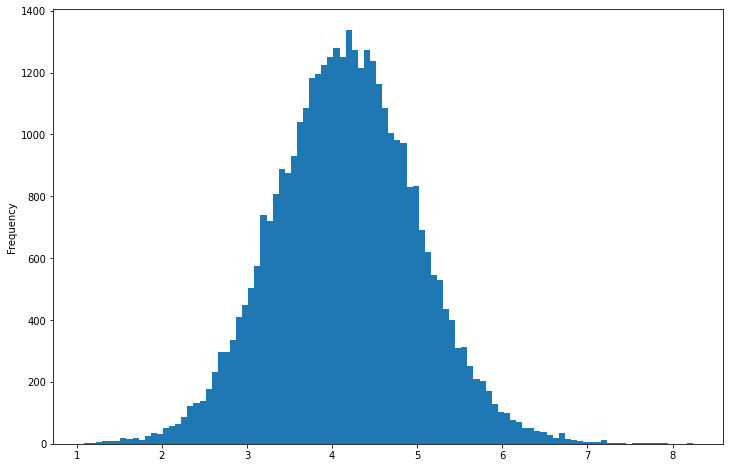

In [94]:
fig = plt.figure(figsize=(12,8))
Mod6['Rq5a'].plot.hist(bins=100)

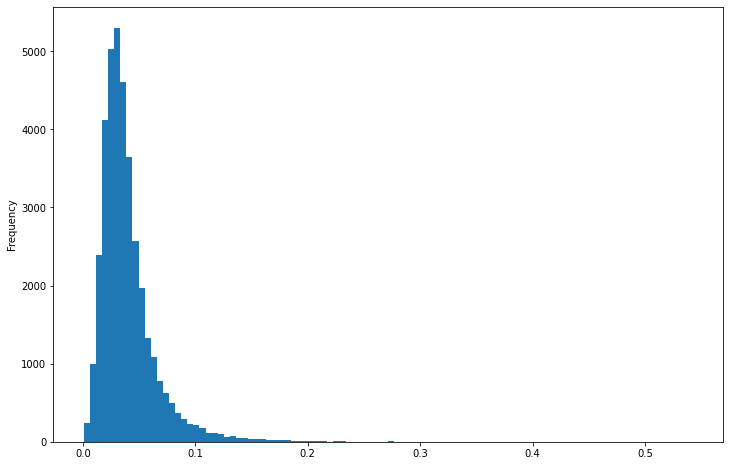

In [95]:
fig = plt.figure(figsize=(12,8))
Mod6['mod_6'].plot.hist(bins=100)

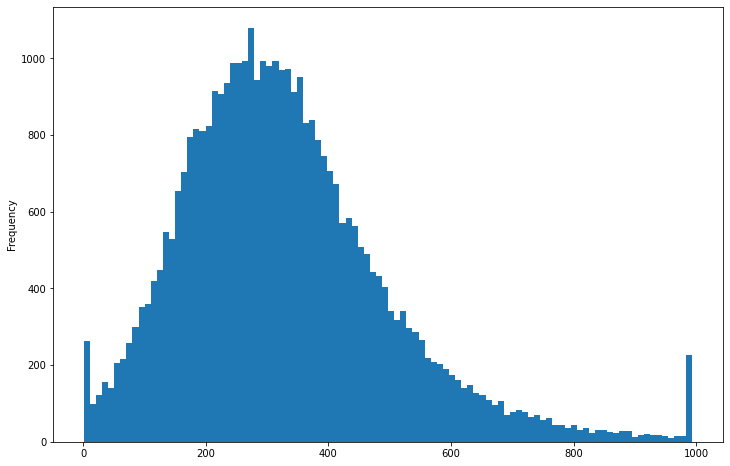

In [96]:
fig = plt.figure(figsize=(12,8))
Mod6['Score'].plot.hist(bins=100)

AxesSubplot(0.125,0.125;0.775x0.755)


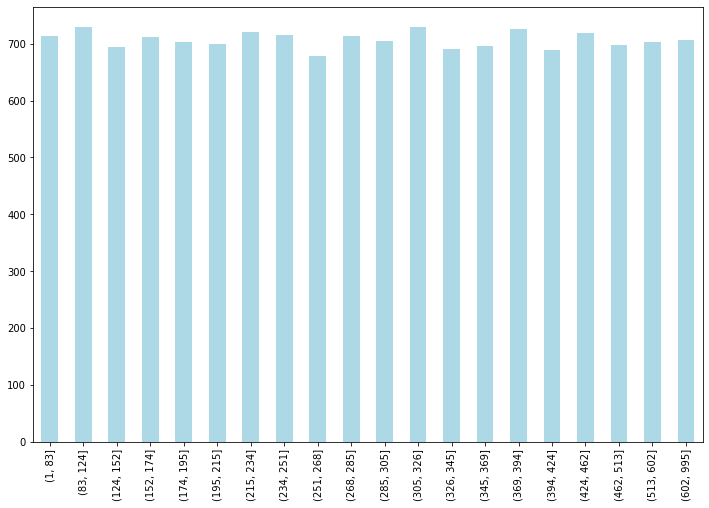

In [97]:
# with the NM2 model you have, calibrated with CMT bounds, can you create a ranked order of scores 1-995 and run a 
# histogram of 20 bins by all drivers, with 5% of drivers for each group 

scoring_data2['CMT_Score_Bin'] = pd.qcut(scoring_data2['NM2_CMT_Score'], q=20)
scoring_data2['CMT_Score_Bin'] = scoring_data2['CMT_Score_Bin'].apply(lambda x: pd.Interval(left=int(round(x.left))
                                                                                            , right=int(round(x.right))))

fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['CMT_Score_Bin'].value_counts(sort=False).sort_index(ascending=True).plot(ax=ax
                                                                                                , kind='bar'
                                                                                                ,color='lightblue'))

In [98]:
# Calculate NM2 CMT rscore based on new bounds
#scoring_data2['NM2_CMT_rscore2']=scoring_data2.NM2_CMT_Score.apply(lambda x: 0.53 if x<=84 else
#                                                    0.54 if x<=126 else
#                                                    0.57 if x<=154 else
#                                                    0.60 if x<=177 else
#                                                    0.64 if x<=198 else
#                                                    0.67 if x<=218 else
#                                                    0.70 if x<=237 else
#                                                    0.71 if x<=254 else
#                                                    0.72 if x<=272 else
#                                                    0.73 if x<=290 else
#                                                    0.74 if x<=310 else
#                                                    0.76 if x<=330 else
#                                                    0.79 if x<=350 else
#                                                    0.82 if x<=374 else
#                                                    0.85 if x<=400 else
#                                                    0.88 if x<=431 else
#                                                    0.91 if x<=468 else
#                                                    0.94 if x<=520 else
#                                                    0.97 if x<=610 else
#                                                    1.0)

scoring_data2['NM2_CMT_rscore2']=scoring_data2.NM2_CMT_Score.apply(lambda x: 0.53 if x<=83 else
                                                    0.54 if x<=124 else
                                                    0.57 if x<=152 else
                                                    0.60 if x<=174 else
                                                    0.64 if x<=195 else
                                                    0.67 if x<=215 else
                                                    0.70 if x<=234 else
                                                    0.71 if x<=251 else
                                                    0.72 if x<=268 else
                                                    0.73 if x<=285 else
                                                    0.74 if x<=305 else
                                                    0.76 if x<=326 else
                                                    0.79 if x<=345 else
                                                    0.82 if x<=369 else
                                                    0.85 if x<=394 else
                                                    0.88 if x<=424 else
                                                    0.91 if x<=462 else
                                                    0.94 if x<=513 else
                                                    0.97 if x<=602 else
                                                    1.0)
# Format to be percent discount
scoring_data2['NM2_CMT_discount_pc2'] = (1-scoring_data2['NM2_CMT_rscore2'])*100

scoring_data2.head()

,short_user_id,adjusted_distance_km,Rq5a,last_trip_date,Max_final_score_date,Min_data_clctn_start_date,NM1_discount_pc,NM1_score_qt,NM1_channel_cd,NM1_rate_state_abbr_nm,...,NM2_discount_pc,NM1_rscore,NM1_discount_pc2,NM1_discount_pc3,NM2_CMT_Score,NM2_CMT_rscore,NM2_CMT_discount_pc,CMT_Score_Bin,NM2_CMT_rscore2,NM2_CMT_discount_pc2
0,10013699,264.6801,4.476129,2021-01-05,2021-01-05,2020-08-19,0.0,998.0,IA,CO,...,47,0.53,47.0,0.00,53.0,0.53,47,"(1, 83]",0.53,47.0
1,10016122,9619.8400,2.726725,2020-12-15,2020-12-15,2020-07-30,29.0,129.0,IA,KS,...,43,0.57,43.0,36.25,198.0,0.64,36,"(195, 215]",0.67,33.0
2,10018353,6455.2721,4.306496,2020-11-07,2020-11-30,2020-07-10,29.0,114.0,EA,NC,...,24,0.76,24.0,36.25,390.0,0.85,15,"(369, 394]",0.85,15.0
3,10019667,3200.1680,4.115618,2020-11-08,2021-02-16,2020-08-28,0.0,998.0,IA,SD,...,28,0.72,28.0,0.00,322.0,0.76,24,"(305, 326]",0.76,24.0
4,10021470,8885.2729,4.157654,2020-12-30,2020-12-30,2020-08-17,21.0,156.0,IA,NJ,...,20,0.79,21.0,26.25,403.0,0.85,15,"(394, 424]",0.88,12.0


AxesSubplot(0.125,0.125;0.775x0.755)


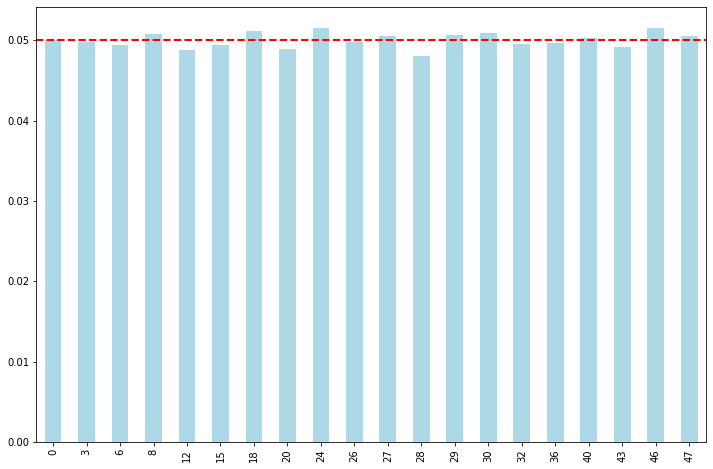

In [99]:
scoring_data2['NM2_CMT_discount_pc2'] = scoring_data2['NM2_CMT_discount_pc2'].astype(np.int64)
fig, ax = plt.subplots(figsize=(12,8))
print(scoring_data2['NM2_CMT_discount_pc2'].value_counts(sort=False
                                                    ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                                     , kind='bar'
                                                                                                    ,color='lightblue'))
ax.axhline(y=0.05, xmin=0, xmax=1, color='r', linestyle='--', lw=2)

In [100]:
scoring_data2.NM2_CMT_discount_pc2.mean()

24.54862878145321

In [101]:
# There is a column called "score" for range 1-995, I want you to use the NM2 discount mapping (original one for NM2) 
# to create a discount chart. Please add 5% line as well. I expect this will give us 20 bars with 5% equally show up, 
# since this was LN dataset we used for model development. 

# Calculate mod6 rscore
Mod6['NM2_rscore']=Mod6.Score.apply(lambda x: 0.53 if x<=98 else
                                                    0.54 if x<=141 else
                                                    0.57 if x<=170 else
                                                    0.60 if x<=193 else
                                                    0.64 if x<=215 else
                                                    0.67 if x<=234 else
                                                    0.70 if x<=252 else
                                                    0.71 if x<=269 else
                                                    0.72 if x<=286 else
                                                    0.73 if x<=303 else
                                                    0.74 if x<=321 else
                                                    0.76 if x<=339 else
                                                    0.79 if x<=358 else
                                                    0.82 if x<=379 else
                                                    0.85 if x<=403 else
                                                    0.88 if x<=432 else
                                                    0.91 if x<=470 else
                                                    0.94 if x<=521 else
                                                    0.97 if x<=612 else
                                                    1.0)
# Format to be percent discount
Mod6['NM2_discount_pc'] = (1-Mod6['NM2_rscore'])*100

Mod6.head()

,policy_nb,ln_telematics_id,active_days,pure_score,avg_ann_adj_KM_pu,Rq5a,mod_6,mod_6_f,Score,NM2_rscore,NM2_discount_pc
0,7701J 056842,803313bf-e264-43c2-b2ec-49c627e6839b,134,166,24659.255992,3.713133,0.031406,0.085546,275.0,0.72,28.0
1,7701J 057986,ea587dfd-1cfe-4677-a937-dbfc63bb046a,121,200,54159.510175,3.589862,0.038605,0.116454,399.0,0.85,15.0
2,7701J 039761,9c532e52-439b-46c5-9699-dd0bdb9e3c56,91,117,4812.620446,6.252848,0.031581,0.126670,440.0,0.91,9.0
3,7701J 055866,b815c3a5-17a0-4180-9919-875bea008152,127,75,3158.192258,4.828008,0.019036,0.054710,152.0,0.57,43.0
4,7701J 053245,48a9a6b3-f2ef-4f02-9200-d0ee3c1b7fba,152,120,5559.427219,3.743341,0.018122,0.043517,107.0,0.54,46.0


In [ ]:
Mod6['NM2_discount_pc'] = Mod6['NM2_discount_pc'].astype(np.int64)
fig, ax = plt.subplots(figsize=(12,8))
print(Mod6['NM2_discount_pc'].value_counts(sort=False
                                           ,normalize=True).sort_index(ascending=True).plot(ax=ax
                                                                                            , kind='bar'
                                                                                            ,color='lightblue'))
ax.axhline(y=0.05, xmin=0, xmax=1, color='r', linestyle='--', lw=2)

In [103]:
Mod6['NM2_discount_pc'].value_counts(sort=False,normalize=True).sort_index(ascending=True)

0     0.060739
3     0.057121
6     0.052001
8     0.053716
12    0.050178
15    0.048463
18    0.046908
20    0.047310
24    0.046211
26    0.048543
27    0.044764
28    0.048892
29    0.045300
30    0.047417
32    0.046399
36    0.049428
40    0.049589
43    0.051894
46    0.050446
47    0.054681
Name: NM2_discount_pc, dtype: float64

In [79]:
test = scoring_data2[['scoring_days','Exp_Year','avg_ann_adj_KM_pu','Rq5a','lEpr','log_avg_ann_adj_KM_pu']]
test.describe()

,scoring_days,Exp_Year,avg_ann_adj_KM_pu,Rq5a,lEpr,log_avg_ann_adj_KM_pu
count,14141.000000,14141.000000,14141.000000,14148.000000,14141.000000,14148.000000
mean,126.740895,0.347235,19780.282207,3.964347,-1.157387,9.505398
std,36.357128,0.099609,18137.131915,0.825534,0.609293,1.013906
min,1.000000,0.002740,1.972431,0.850992,-5.899897,0.679267
25%,121.000000,0.331507,8351.297503,3.412615,-1.104107,9.030288
50%,136.000000,0.372603,15712.507326,3.958326,-0.987242,9.662457
75%,141.000000,0.386301,26342.705016,4.497621,-0.951137,10.179998
max,269.000000,0.736986,393289.223795,8.414237,-0.305186,11.512925


In [91]:
test = scoring_data2.dropna()
test['scoring_days'] = test['scoring_days'].astype(np.int64) 
test2 = test[test['scoring_days']<85]
test2.shape

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1504, 35)

In [92]:
test = scoring_data2.dropna()
test2 = test[test['Exp_Year']<0.2329]
test2.shape

(1521, 35)

In [94]:
test = scoring_data2.dropna()
test2 = test[(test['avg_ann_adj_KM_pu']<3.85)|(test['avg_ann_adj_KM_pu']>347497.71)]
test2.shape

(3, 35)

In [95]:
test = scoring_data2.dropna()
test2 = test[(test['Rq5a']<1.0848)|(test['Rq5a']>8.2359)]
test2.shape

(5, 35)

In [96]:
test = scoring_data2.dropna()
test2 = test[test['lEpr']<-1.4572]
test2.shape

(1521, 35)

In [97]:
test = scoring_data2.dropna()
test2 = test[test['log_avg_ann_adj_KM_pu']<1.3490]
test2.shape

(1, 35)

### Heartbeat File Quality Checks

In [94]:
# Use Grace's Old Table

# Read in previously pulled data up to 10/22/2020:
CMT_Heartbeat = pd.read_csv("/home/lengj/data/temp/CMT_Heartbeat_102220.csv", low_memory=False)
print(CMT_Heartbeat.shape)
CMT_Heartbeat.head()
# (2722140, 4)

(2722140, 4)


,short_user_id,registration_date,Last_request_date,load_date
0,10193404,2020-06-11 18:21:12.236661,2020-06-16 03:04:37.529191,2020-06-13
1,10276157,2020-06-07 03:06:57.803742,2020-06-16 03:24:17.564080,2020-06-13
2,11011499,2020-06-13 00:48:52.384329,2020-06-16 02:28:18.040259,2020-06-13
3,11029700,2020-06-08 16:17:26.167208,2020-06-16 01:29:22.535200,2020-06-13
4,11059273,2020-01-28 18:31:06.980466,2020-06-16 02:58:42.643974,2020-06-13


In [86]:
# Read in New Table

# Read in Heartbeat data 
Heartbeat_After = pd.read_csv("Heartbeat_After_3092021.csv", low_memory = False)

# Show head
print(Heartbeat_After.shape)
Heartbeat_After.head()

(9089669, 7)


,short_user_id,email,registration_date,Last_request_date,Last_upload_date,_col5,load_date
0,11059273,gouvrit@gmail.com,2020-01-28 18:31:06.980466,2020-06-09 23:17:21.299678,2020-06-09 23:17:22.000000,2021-03-09,2020-06-07
1,19902054,metekov.shavkat@gmail.com,2020-06-07 03:34:06.808755,2020-06-09 19:49:44.645677,2020-06-09 19:49:46.000000,2021-03-09,2020-06-07
2,19936997,wmflis@yahoo.com,2020-06-07 04:30:44.690455,2020-06-10 00:15:24.039893,2020-06-10 00:15:25.000000,2021-03-09,2020-06-07
3,22785521,calval@nationwide.com,2019-05-17 17:15:58.609290,2020-06-09 21:46:55.948165,2020-06-09 21:57:26.000000,2021-03-09,2020-06-07
4,27185796,eagosto_jr@yahoo.com,2020-06-06 18:26:47.869630,2020-06-10 00:04:36.093867,2020-06-10 00:09:31.000000,2021-03-09,2020-06-07


In [89]:
# Merge new with old heartbeat

# First only select needed variables
Heartbeat_After = Heartbeat_After[['short_user_id','registration_date','Last_request_date','load_date']]

# Merge 
Heartbeat_Missing = pd.merge(CMT_Heartbeat, Heartbeat_After, on=('short_user_id','registration_date'
                                                                 ,'Last_request_date','load_date'), how='left')
print(Heartbeat_Missing.shape)
Heartbeat_Missing.head()
Heartbeat_Missing['load_date'].isna().value_counts()

(2722140, 4)


False    2722140
Name: load_date, dtype: int64

In [90]:
Heartbeat_After.Last_request_date.value_counts().sort_index()

2019-06-27 21:23:02.093767    239
2019-06-27 21:25:00.050777    266
2019-07-06 17:11:41.184579    266
2019-07-11 19:26:08.959605    266
2019-07-29 15:03:34.916057    266
                             ... 
2021-03-09 06:46:06.121557      1
2021-03-09 06:46:06.555323      1
2021-03-09 06:46:08.383255      1
2021-03-09 06:46:08.419177      1
2021-03-09 06:46:10.199037      1
Name: Last_request_date, Length: 3517902, dtype: int64

In [91]:
CMT_Heartbeat.Last_request_date.value_counts().sort_index()

2019-06-27 21:23:02.093767    129
2019-06-27 21:25:00.050777    129
2019-07-06 17:11:41.184579    129
2019-07-11 19:26:08.959605    129
2019-07-29 15:03:34.916057    129
                             ... 
2020-10-22 05:53:46.609533      1
2020-10-22 05:53:50.135398      1
2020-10-22 05:53:50.227868      1
2020-10-22 05:53:51.318522      1
2020-10-22 05:53:55.674009      1
Name: Last_request_date, Length: 978548, dtype: int64

In [92]:
# Filter Heartbeat_After by Grace's data max Last_request_date
Heartbeat_Filter = Heartbeat_After[Heartbeat_After['Last_request_date']<'2020-10-23']
print(Heartbeat_Filter.shape)
Heartbeat_Filter.head()

# Grace File = 2,722,140
# Mine =       1,489,015

(1489015, 4)


,short_user_id,registration_date,Last_request_date,load_date
0,11059273,2020-01-28 18:31:06.980466,2020-06-09 23:17:21.299678,2020-06-07
1,19902054,2020-06-07 03:34:06.808755,2020-06-09 19:49:44.645677,2020-06-07
2,19936997,2020-06-07 04:30:44.690455,2020-06-10 00:15:24.039893,2020-06-07
3,22785521,2019-05-17 17:15:58.609290,2020-06-09 21:46:55.948165,2020-06-07
4,27185796,2020-06-06 18:26:47.869630,2020-06-10 00:04:36.093867,2020-06-07


In [93]:
Heartbeat_Filter.Last_request_date.value_counts().sort_index()

2019-06-27 21:23:02.093767    239
2019-06-27 21:25:00.050777    266
2019-07-06 17:11:41.184579    266
2019-07-11 19:26:08.959605    266
2019-07-29 15:03:34.916057    266
                             ... 
2020-10-22 23:59:37.886627      1
2020-10-22 23:59:39.465728      1
2020-10-22 23:59:50.203601      1
2020-10-22 23:59:56.374459      1
2020-10-22 23:59:56.430109      1
Name: Last_request_date, Length: 983394, dtype: int64

In [101]:
merged = Heartbeat_Filter.merge(CMT_Heartbeat, how='left', indicator=True)

In [102]:
merged[merged['_merge']=='left_only']
# We have 1,459,175 with no match 
# 226,050 of items in my Heartbeat are not in Grace's

,short_user_id,registration_date,Last_request_date,load_date,_merge
2369,10085463,2020-09-14 01:11:26.209937,2020-10-14 13:38:19.939487,2021-02-20,left_only
2370,10270126,2020-09-01 20:19:22.645516,2020-10-04 21:09:40.301385,2021-02-20,left_only
2371,10333741,2020-07-07 18:30:53.036177,2020-07-31 01:07:23.069323,2021-02-20,left_only
2372,10372294,2020-08-07 16:13:39.105364,2020-09-13 16:42:35.170287,2021-02-20,left_only
2373,10437819,2020-06-22 20:21:42.851700,2020-09-28 18:33:53.177752,2021-02-20,left_only
...,...,...,...,...,...
1489010,99569790,2020-09-23 18:01:30.121392,2020-10-03 19:45:02.134436,2020-11-15,left_only
1489011,99609303,2020-09-23 20:36:15.768624,2020-10-06 20:31:58.022165,2020-11-15,left_only
1489012,99733108,2020-08-09 15:49:01.256777,2020-09-23 16:22:20.713514,2020-11-15,left_only
1489013,99825844,2020-08-07 00:08:14.398922,2020-08-07 00:08:15.305310,2020-11-15,left_only


In [107]:
merged[merged['_merge']=='both']
# 1,262,965 that have a match 

,short_user_id,registration_date,Last_request_date,load_date,_merge
0,11059273,2020-01-28 18:31:06.980466,2020-06-09 23:17:21.299678,2020-06-07,both
1,19902054,2020-06-07 03:34:06.808755,2020-06-09 19:49:44.645677,2020-06-07,both
2,19936997,2020-06-07 04:30:44.690455,2020-06-10 00:15:24.039893,2020-06-07,both
3,22785521,2019-05-17 17:15:58.609290,2020-06-09 21:46:55.948165,2020-06-07,both
4,27185796,2020-06-06 18:26:47.869630,2020-06-10 00:04:36.093867,2020-06-07,both
...,...,...,...,...,...
1488603,99968455,2020-08-21 15:08:40.341597,2020-10-08 05:36:30.695481,2020-10-07,both
1488604,99970378,2020-06-13 15:58:42.139760,2020-10-07 21:42:24.308213,2020-10-07,both
1488605,99971711,2020-10-02 15:55:40.045809,2020-10-08 04:27:30.649367,2020-10-07,both
1488606,99991218,2020-07-27 20:47:06.995193,2020-10-07 23:38:15.037896,2020-10-07,both


In [108]:
notmissing = merged[merged['_merge']=='both']
notmissing = notmissing[['short_user_id','registration_date','Last_request_date','load_date']]
CMT_Heartbeat_Missing = pd.merge(CMT_Heartbeat, notmissing, how='outer', indicator=True)
print(CMT_Heartbeat_Missing.shape)
CMT_Heartbeat_Missing.head()

(2722140, 5)


,short_user_id,registration_date,Last_request_date,load_date,_merge
0,10193404,2020-06-11 18:21:12.236661,2020-06-16 03:04:37.529191,2020-06-13,both
1,10276157,2020-06-07 03:06:57.803742,2020-06-16 03:24:17.564080,2020-06-13,both
2,11011499,2020-06-13 00:48:52.384329,2020-06-16 02:28:18.040259,2020-06-13,both
3,11029700,2020-06-08 16:17:26.167208,2020-06-16 01:29:22.535200,2020-06-13,both
4,11059273,2020-01-28 18:31:06.980466,2020-06-16 02:58:42.643974,2020-06-13,both


In [115]:
CMT_Heartbeat_Missing[CMT_Heartbeat_Missing['_merge']=='left_only']

,short_user_id,registration_date,Last_request_date,load_date,_merge
592,10005257,NaN,NaN,2020-06-30,left_only
593,10012488,NaN,NaN,2020-06-30,left_only
594,10012582,NaN,NaN,2020-06-30,left_only
595,10017832,NaN,NaN,2020-06-30,left_only
596,10021571,NaN,NaN,2020-06-30,left_only
...,...,...,...,...,...
2722133,99976911,NaN,NaN,2020-09-05,left_only
2722134,99985188,NaN,NaN,2020-09-05,left_only
2722135,99985523,NaN,NaN,2020-09-05,left_only
2722137,99991680,NaN,NaN,2020-09-05,left_only


In [113]:
export = CMT_Heartbeat_Missing[CMT_Heartbeat_Missing['_merge']=='left_only']

In [114]:
export.to_csv('/home/thoms70/notebooks/Heartbeat_Missing_Data3252021.csv', index = False)

In [112]:
test = CMT_Heartbeat[CMT_Heartbeat['short_user_id']==10012488]
test

,short_user_id,registration_date,Last_request_date,load_date
593,10012488,NaN,NaN,2020-06-30
11042,10012488,NaN,NaN,2020-07-24
15412,10012488,NaN,NaN,2020-08-03
19782,10012488,NaN,NaN,2020-07-14
24151,10012488,NaN,NaN,2020-07-05
...,...,...,...,...
1155990,10012488,NaN,NaN,2020-08-22
1356719,10012488,NaN,NaN,2020-08-12
1446766,10012488,NaN,NaN,2020-08-15
1942231,10012488,NaN,NaN,2020-08-17
